In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

from tqdm import tqdm
import yaml

from scipy.stats import binned_statistic_2d
# import shap

from flash_ansr import get_path, ExpressionSpace
from flash_ansr.eval.utils import bootstrapped_metric_ci

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

In [2]:
def nan_false_statistic(X, statistic):
    X_copy = np.array(X)
    # Where X is nan, replace with False
    X_copy[np.isnan(X_copy)] = False
    return statistic(X_copy)

In [3]:
MODELS = [os.path.join('analysis_beams', m) for m in os.listdir(get_path('results', 'evaluation', 'analysis_beams'))]

In [4]:
MODELS_DESCRIPTION = {k: k.replace('v6.0_', '') for k in MODELS}

In [ ]:
TEST_SETS = ['train', 'val', 'feynman', 'soose_nc', 'nguyen', 'pool_15']
TEST_SET_TITLES = {
    'train': 'Train',
    'val': 'Val',
    'feynman': 'Feynman',
    'soose_nc': 'S.-NC',
    'nguyen': 'Nguyen',
    'pool_15': 'Pool 15',
}

In [6]:
configs = {}

for model in MODELS:
    with open(get_path(f'configs/{model}/evaluation.yaml'), 'r') as f:
        configs[model] = yaml.safe_load(f)

In [7]:
test_sets = {model: [path.replace('.pickle', '') for path in os.listdir(get_path(f'results/evaluation/{model}'))] for model in MODELS}

for model, model_test_sets in test_sets.items():
    # Reorder the test sets as follows: train, val, feynman, soose_nc, nguyen
    for i, s in enumerate(TEST_SETS):
        if s in model_test_sets:
            model_test_sets.remove(s)
            model_test_sets.insert(i, s)

In [8]:
results = {}

for model, model_test_sets in test_sets.items():
    results[model] = {test_set: {'path': get_path(f'results/evaluation/{model}/{test_set}.pickle')} for test_set in model_test_sets}

In [9]:
remove_invalid = []

for model, model_results in results.items():
    for test_set, test_set_results in tqdm(model_results.items(), desc=f'Loading {model} results'):
        with open(test_set_results['path'], 'rb') as f:
            test_set_results['data'] = pickle.load(f)

            columns_to_rename = set()
            for k, v in test_set_results['data'].items():
                try:
                    test_set_results['data'][k] = np.array(v)
                except ValueError:
                    pass

                if '_free_' in k:
                    columns_to_rename.add(k)

            for k in columns_to_rename:
                test_set_results['data'][k.replace('_free_', '_')] = test_set_results['data'][k]
                del test_set_results['data'][k]

            keys_to_remove = [k for k in test_set_results['data'].keys() if 'residuals' in k]
            keys_to_remove.extend(['x', 'y'])

            for k in keys_to_remove:
                del test_set_results['data'][k]

Loading analysis_beams/v6.0_2-beams results: 100%|██████████| 4/4 [00:00<00:00,  4.50it/s]


In [10]:
for model, model_results in results.items():
    n_beams = configs[model].get('n_beams', 1)
    n_restarts = configs[model].get('n_restarts', 1)
    # Pad the beams to their maximum length
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        if model == 'pysr':
            results[model][test_set]['data']['wall_time'] = data['fit_time']
            results[model][test_set]['data']['sys_time'] = data['fit_time'] * 32  # 32 cores
        
        elif model == 'nesymres-100M':
            results[model][test_set]['data']['wall_time'] = data['fit_time']
            results[model][test_set]['data']['sys_time'] = data['fit_time']

        else:
            results[model][test_set]['data']['wall_time'] = data['beam_search_time'] + sum(data[f'refiner_time_beam_{j + 1}'] for j in range(n_beams))
            results[model][test_set]['data']['sys_time'] = data['beam_search_time'] + sum(data[f'refiner_time_beam_{j + 1}'] for j in range(n_beams)) * n_restarts  # Each restart is run in parallel

100%|██████████| 4/4 [00:00<00:00, 10034.22it/s]


In [11]:
for model, model_results in results.items():
    n_beams = configs[model].get('n_beams', 1)
    # Pad the beams to their maximum length
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        results[model][test_set]['data']['length_target'] = np.array([len(data['input_ids'][i]) for i in range(len(data['input_ids']))])
        
        for j in range(n_beams):
            results[model][test_set]['data'][f'length_beam_{j + 1}'] = np.array([len(data[f'free_beam_{j + 1}'][i]) for i in range(len(data[f'free_beam_{j + 1}']))])

            if f'residuals_beam_{j + 1}' not in data:
                continue
            results[model][test_set]['data'][f'L_inf_beam_{j + 1}'] = np.array([(np.nanmax(np.abs(data[f'residuals_beam_{j + 1}'][i])) if data[f'residuals_beam_{j + 1}'][i] is not None else np.nan) for i in range(len(data[f'residuals_beam_{j + 1}']))])
        
        if '_beam_1' not in data:
            continue

        max_length = max(max([len(beam) for beam in data[f'_beam_{j + 1}']]) for j in range(n_beams))

        for j in range(n_beams):
            padded_beam = [beam + [0] * (max_length - len(beam)) for beam in data[f'_beam_{j + 1}']]
            data[f'_beam_{j + 1}'] = np.array(padded_beam)


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 2001.34it/s]


In [12]:
for model, model_results in results.items():
    n_beams = configs[model].get('n_beams', 1)
    for test_set, test_set_results in tqdm(model_results.items()):
        valid = True
        data = test_set_results['data']

        beam_columns = [k.replace('_beam_1', '') for k in data.keys() if k.endswith(f'beam_1') and not 'residuals' in k and not 'free' in k]

        # Create new columns with metrics of the best beam (by mse_{generation_type}_beam_{i}) and store it as {metric}_{generation_type}_best_beam
        # Create new columns
        for column in beam_columns:
            if isinstance(data[column + '_beam_1'][0], np.ndarray):
                data[column + '_best_beam'] = np.nan * np.ones_like(data[column + '_beam_1'])
            else:
                data[column + '_best_beam'] = np.nan * np.ones(len(data[column + '_beam_1']))

        data['best_beam'] = np.nan * np.ones(len(data['mse_beam_1']))

        # For each instance, find the best beam by mse
        for i in range(len(data['mse_beam_1'])):
            mse_list = np.array([data[f'mse_beam_{j}'][i] for j in range(1, n_beams+1) if f'mse_beam_{j}' in data.keys()])
            if np.all(np.isnan(mse_list)):
                continue
            best_beam = np.nanargmin([data[f'mse_beam_{j}'][i] for j in range(1, n_beams+1) if f'mse_beam_{j}' in data.keys()]) + 1
            data['best_beam'][i] = best_beam
            for column in beam_columns:
                data[column + '_best_beam'][i] = data[column + f'_beam_{best_beam}'][i]

100%|██████████| 4/4 [00:00<00:00, 50.63it/s]


In [13]:
# Design features
for model, model_results in results.items():
    for test_set, test_set_results in model_results.items():
        test_set_results['data']['FVU-eps_accuracy'] = [(1 - r2) <= np.finfo(np.float32).eps for r2 in test_set_results['data']['r2_best_beam']]
        test_set_results['data']['log_fvu'] = [np.log10(1 - r2 + np.finfo(np.float32).eps) for r2 in test_set_results['data']['r2_best_beam']]
        test_set_results['data']['fvu'] = [1 - r2 for r2 in test_set_results['data']['r2_best_beam']]
        test_set_results['data']['is_finite'] = [np.isfinite(r2) for r2 in test_set_results['data']['r2_best_beam']]

        if 'perplexity' in test_set_results['data']:
            test_set_results['data']['log_ppl'] = [np.log10(ppl) for ppl in test_set_results['data']['perplexity']]
        else:
            test_set_results['data']['log_ppl'] = [np.nan] * len(test_set_results['data']['r2_best_beam'])

In [14]:
# Find the intersection of the columns of all the dataframes
compare_columns = set.union(*[set(test_set_results['data'].keys()) for model_results in results.values() for test_set_results in model_results.values()])
compare_columns = compare_columns - {'x', 'y', 'constants', 'input_ids', 'labels', 'residuals_beam_1', 'n_support', 'free_best_beam'}
compare_columns = compare_columns - {c for c in compare_columns if any(c.endswith(f'_{i}') or 'free' in c for i in range(1, 1024))}
# compare_columns = compare_columns.union({'perplexity', 'precision_best_beam', 'recall_best_beam', 'meteor_best_beam', 'edit_distance'})
compare_columns

{'FVU-eps_accuracy',
 'NSRTS_accuracy_close_best_beam',
 'NSRTS_accuracy_r2_best_beam',
 'accuracy_best_beam',
 'beam_search_time',
 'best_beam',
 'bleu_best_beam',
 'edit_distance_best_beam',
 'f1_score_best_beam',
 'fvu',
 'is_finite',
 'length_best_beam',
 'length_target',
 'log_fvu',
 'log_ppl',
 'meteor_best_beam',
 'mse_best_beam',
 'perplexity',
 'precision_best_beam',
 'r2_best_beam',
 'recall_best_beam',
 'reciprocal_rank',
 'refiner_time_best_beam',
 'rouge1_fmeasure_best_beam',
 'rouge1_precision_best_beam',
 'rouge1_recall_best_beam',
 'rouge2_fmeasure_best_beam',
 'rouge2_precision_best_beam',
 'rouge2_recall_best_beam',
 'rougeL_fmeasure_best_beam',
 'rougeL_precision_best_beam',
 'rougeL_recall_best_beam',
 'structural_accuracy_best_beam',
 'sys_time',
 'tree_edit_distance_best_beam',
 'wall_time'}

In [15]:
array_dfs = {
    model: {
        test_set:
        pd.DataFrame({k: v for k, v in test_set_results['data'].items() if k in compare_columns}).astype(float)
            for test_set, test_set_results in model_results.items()}
            for model, model_results in results.items()}

In [16]:
compare_columns_defaults = {
    'FVU-eps_accuracy': 0,
    'perplexity': np.inf,
    'log_ppl': np.inf,
    'precision_best_beam': 0,
    'recall_best_beam': 0,
    'L_inf_best_beam': np.inf,
    'NSRTS_accuracy_close_best_beam': 0,
    'NSRTS_accuracy_r2_best_beam': 0,
    'accuracy_best_beam': 0,
    'bleu_best_beam': 0,
    'edit_distance_best_beam': np.inf,
    'f1_score_best_beam': 0,
    'log_fvu': np.inf,
    'log_ppl': np.inf,
    'meteor_best_beam': 0,
    'mse_best_beam': np.inf,
    'perplexity': np.inf,
    'precision_best_beam': 0,
    'r2_best_beam': -np.inf,
    'recall_best_beam': 0,
    'reciprocal_rank': 0,
    'rouge1_fmeasure_best_beam': 0,
    'rouge1_precision_best_beam': 0,
    'rouge1_recall_best_beam': 0,
    'rouge2_fmeasure_best_beam': 0,
    'rouge2_precision_best_beam': 0,
    'rouge2_recall_best_beam': 0,
    'rougeL_fmeasure_best_beam': 0,
    'rougeL_precision_best_beam': 0,
    'rougeL_recall_best_beam': 0,
    'structural_accuracy_best_beam': 0,
    'tree_edit_distance_best_beam': np.inf,
    'wall_time': np.inf,
    'sys_time': np.inf,
    'is_finite': 0,
}

In [17]:
from functools import partial

In [18]:
def naninfmean(x):
    return np.nanmean(np.array(x)[np.isfinite(x)])

# Per Dataset

In [19]:
summaries = {model: {test_set: {column: {} for column in compare_columns} for test_set, df in model_dfs.items()} for model, model_dfs in array_dfs.items()}
metrics = None

N_BOOTSTRAPS = 1_000

for model, model_dfs in array_dfs.items():
    for test_set, df in model_dfs.items():
        for column in tqdm(compare_columns, desc=f'{model} {test_set}'):
            sub_metrics = ['mean', 'median', '2.5p', '97.5p']
            sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]
            if column in df.columns:
                data = df[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
                summaries[model][test_set][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}
            else:
                summaries[model][test_set][column] = {k: (np.nan, ) * 3 for k in sub_metrics}

            if metrics is None:
                metrics = summaries[model][test_set][column].keys()

analysis_beams/v6.0_128-beams feynman:  86%|████████▌ | 31/36 [00:04<00:00,  9.65it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
analysis_beams/v6.0_1-beams feynman:  58%|█████▊    | 21/36 [00:03<00:01,  7.94it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4622: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
analysis_beams/v6.0_2-beams pool_15: 100%|██████████| 36/36 [00:04<00:00,  7.44it/s]


In [20]:
# Show a summary table for each metric
# In each table, the rows are the models and the columns are the test sets
# For columns with 'accuracy' in the name, show the mean. For other columns show the median.

summary_tables = {
    column: {
        metric: {
            percentile:
                pd.DataFrame({
                model: {
                    test_set: summaries[model][test_set][column][metric][k]
                    for test_set in summaries[model].keys()}
                    for model in summaries.keys()}).T.round(3)
                    for k, percentile in enumerate(['median', 'lower', 'upper'])}
                    for metric in metrics}
                    for column in compare_columns}

#### Validity

In [21]:
m = 'is_finite'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams/v6.0_128-beams,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_beams/v6.0_16-beams,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","0.999 (0.997, 1.0)","0.999 (0.997, 1.0)"
analysis_beams/v6.0_32-beams,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_beams/v6.0_64-beams,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_beams/v6.0_8-beams,"1.0 (1.0, 1.0)","0.999 (0.997, 1.0)","0.999 (0.997, 1.0)","0.998 (0.995, 1.0)"
analysis_beams/v6.0_4-beams,"0.999 (0.997, 1.0)","1.0 (1.0, 1.0)","0.998 (0.995, 1.0)","0.992 (0.986, 0.997)"
analysis_beams/v6.0_1-beams,"0.972 (0.962, 0.981)","0.982 (0.972, 0.989)","0.988 (0.981, 0.994)","0.971 (0.96, 0.98)"
analysis_beams/v6.0_2-beams,"0.992 (0.986, 0.997)","0.995 (0.99, 0.999)","0.993 (0.988, 0.998)","0.988 (0.981, 0.995)"


#### Recovery Rate

In [22]:
m = 'NSRTS_accuracy_close_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams/v6.0_128-beams,"0.944 (0.928, 0.957)","0.882 (0.861, 0.902)","0.953 (0.94, 0.966)","0.694 (0.666, 0.723)"
analysis_beams/v6.0_16-beams,"0.866 (0.843, 0.886)","0.793 (0.768, 0.818)","0.81 (0.784, 0.834)","0.599 (0.569, 0.631)"
analysis_beams/v6.0_32-beams,"0.884 (0.864, 0.903)","0.829 (0.804, 0.85)","0.874 (0.852, 0.895)","0.643 (0.612, 0.671)"
analysis_beams/v6.0_64-beams,"0.915 (0.898, 0.932)","0.856 (0.835, 0.878)","0.917 (0.899, 0.933)","0.689 (0.662, 0.718)"
analysis_beams/v6.0_8-beams,"0.821 (0.796, 0.843)","0.753 (0.728, 0.779)","0.798 (0.771, 0.822)","0.578 (0.548, 0.608)"
analysis_beams/v6.0_4-beams,"0.762 (0.737, 0.79)","0.685 (0.657, 0.712)","0.731 (0.704, 0.758)","0.523 (0.491, 0.554)"
analysis_beams/v6.0_1-beams,"0.642 (0.612, 0.672)","0.494 (0.464, 0.527)","0.563 (0.531, 0.594)","0.415 (0.385, 0.446)"
analysis_beams/v6.0_2-beams,"0.691 (0.661, 0.721)","0.571 (0.54, 0.602)","0.621 (0.592, 0.652)","0.46 (0.428, 0.491)"


In [23]:
m = 'NSRTS_accuracy_r2_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams/v6.0_128-beams,"0.98 (0.971, 0.989)","0.925 (0.908, 0.941)","0.994 (0.989, 0.999)","0.866 (0.844, 0.887)"
analysis_beams/v6.0_16-beams,"0.922 (0.905, 0.938)","0.849 (0.826, 0.87)","0.976 (0.966, 0.985)","0.798 (0.775, 0.823)"
analysis_beams/v6.0_32-beams,"0.941 (0.927, 0.955)","0.874 (0.853, 0.893)","0.982 (0.973, 0.99)","0.821 (0.799, 0.843)"
analysis_beams/v6.0_64-beams,"0.97 (0.958, 0.979)","0.9 (0.881, 0.919)","0.992 (0.986, 0.997)","0.855 (0.834, 0.877)"
analysis_beams/v6.0_8-beams,"0.904 (0.886, 0.922)","0.83 (0.807, 0.853)","0.953 (0.94, 0.966)","0.77 (0.743, 0.796)"
analysis_beams/v6.0_4-beams,"0.85 (0.826, 0.871)","0.766 (0.742, 0.792)","0.93 (0.914, 0.945)","0.705 (0.675, 0.732)"
analysis_beams/v6.0_1-beams,"0.741 (0.714, 0.768)","0.595 (0.563, 0.626)","0.778 (0.751, 0.803)","0.549 (0.517, 0.58)"
analysis_beams/v6.0_2-beams,"0.796 (0.769, 0.821)","0.672 (0.643, 0.701)","0.818 (0.794, 0.841)","0.621 (0.593, 0.65)"


In [24]:
m = 'FVU-eps_accuracy'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams/v6.0_128-beams,"0.837 (0.814, 0.86)","0.799 (0.774, 0.823)","0.911 (0.893, 0.928)","0.428 (0.398, 0.455)"
analysis_beams/v6.0_16-beams,"0.74 (0.713, 0.766)","0.686 (0.657, 0.715)","0.661 (0.632, 0.69)","0.32 (0.292, 0.35)"
analysis_beams/v6.0_32-beams,"0.767 (0.742, 0.793)","0.738 (0.712, 0.765)","0.739 (0.711, 0.766)","0.374 (0.344, 0.406)"
analysis_beams/v6.0_64-beams,"0.805 (0.779, 0.828)","0.78 (0.754, 0.804)","0.841 (0.819, 0.863)","0.421 (0.391, 0.45)"
analysis_beams/v6.0_8-beams,"0.684 (0.656, 0.712)","0.619 (0.587, 0.648)","0.586 (0.555, 0.617)","0.302 (0.275, 0.332)"
analysis_beams/v6.0_4-beams,"0.64 (0.611, 0.669)","0.55 (0.52, 0.584)","0.539 (0.508, 0.569)","0.299 (0.27, 0.329)"
analysis_beams/v6.0_1-beams,"0.545 (0.513, 0.574)","0.393 (0.362, 0.424)","0.421 (0.393, 0.452)","0.202 (0.178, 0.229)"
analysis_beams/v6.0_2-beams,"0.584 (0.555, 0.612)","0.463 (0.432, 0.495)","0.448 (0.416, 0.479)","0.226 (0.2, 0.25)"


#### Numeric Error

In [25]:
m = 'fvu'
sm = '97.5p'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams/v6.0_128-beams,"0.01 (0.005, 0.081)","0.997 (0.989, 0.999)","0.002 (0.0, 0.006)","0.962 (0.881, 0.994)"
analysis_beams/v6.0_16-beams,"0.974 (0.87, 0.991)","1.439 (1.106, 1.613)","0.032 (0.008, 0.109)","1.011 (1.0, 1.111)"
analysis_beams/v6.0_32-beams,"0.848 (0.561, 0.941)","1.111 (1.001, 1.444)","0.008 (0.003, 0.081)","1.0 (0.986, 1.003)"
analysis_beams/v6.0_64-beams,"0.116 (0.024, 0.534)","0.999 (0.997, 1.006)","0.007 (0.001, 0.019)","0.983 (0.935, 0.996)"
analysis_beams/v6.0_8-beams,"0.994 (0.971, 0.999)","1.674 (1.579, 1.714)","0.168 (0.094, 0.395)","1.553 (1.011, 1.738)"
analysis_beams/v6.0_4-beams,"1.0 (0.999, 1.003)","1.746 (1.703, 1.776)","0.752 (0.506, 1.077)","2.031 (1.672, 4.116)"
analysis_beams/v6.0_1-beams,"7.718 (4.042, 23.298)","6.678 (4.0, 9.616)","4.526 (3.138, 6.821)","60.577 (22.003, 181.457)"
analysis_beams/v6.0_2-beams,"2.226 (1.282, 4.018)","3.38 (2.685, 4.068)","3.179 (2.739, 4.378)","20.549 (4.509, 55.558)"


#### Time

In [26]:
m = 'wall_time'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams/v6.0_128-beams,"12.046 (11.913, 12.217)","13.147 (12.986, 13.269)","8.383 (8.31, 8.438)","8.905 (8.806, 8.978)"
analysis_beams/v6.0_16-beams,"2.091 (2.06, 2.117)","2.01 (1.96, 2.045)","2.116 (2.085, 2.142)","2.225 (2.202, 2.25)"
analysis_beams/v6.0_32-beams,"3.64 (3.599, 3.686)","3.463 (3.382, 3.508)","3.743 (3.705, 3.774)","3.782 (3.738, 3.85)"
analysis_beams/v6.0_64-beams,"7.152 (7.077, 7.195)","6.774 (6.713, 6.821)","6.841 (6.795, 6.9)","7.548 (7.467, 7.642)"
analysis_beams/v6.0_8-beams,"1.121 (1.1, 1.152)","1.12 (1.093, 1.151)","1.156 (1.129, 1.187)","1.172 (1.14, 1.203)"
analysis_beams/v6.0_4-beams,"0.645 (0.619, 0.672)","0.674 (0.654, 0.698)","0.707 (0.689, 0.721)","0.666 (0.643, 0.689)"
analysis_beams/v6.0_1-beams,"0.107 (0.102, 0.112)","0.103 (0.099, 0.107)","0.09 (0.087, 0.093)","0.157 (0.151, 0.164)"
analysis_beams/v6.0_2-beams,"0.346 (0.319, 0.393)","0.27 (0.244, 0.29)","0.392 (0.341, 0.414)","0.332 (0.31, 0.356)"


In [27]:
m = 'sys_time'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams/v6.0_128-beams,"15.346 (15.102, 15.798)","15.814 (15.566, 16.2)","11.153 (10.944, 11.496)","12.427 (11.824, 13.078)"
analysis_beams/v6.0_16-beams,"2.368 (2.323, 2.437)","2.268 (2.23, 2.304)","2.401 (2.369, 2.437)","2.653 (2.569, 2.717)"
analysis_beams/v6.0_32-beams,"4.287 (4.222, 4.362)","3.967 (3.918, 4.049)","4.386 (4.332, 4.452)","4.67 (4.562, 4.754)"
analysis_beams/v6.0_64-beams,"8.522 (8.42, 8.674)","7.977 (7.847, 8.104)","8.091 (7.992, 8.2)","9.313 (9.119, 9.56)"
analysis_beams/v6.0_8-beams,"1.274 (1.229, 1.306)","1.258 (1.228, 1.29)","1.3 (1.274, 1.318)","1.386 (1.344, 1.441)"
analysis_beams/v6.0_4-beams,"0.717 (0.698, 0.745)","0.753 (0.728, 0.767)","0.77 (0.749, 0.794)","0.804 (0.775, 0.839)"
analysis_beams/v6.0_1-beams,"0.124 (0.117, 0.129)","0.114 (0.108, 0.12)","0.098 (0.094, 0.101)","0.182 (0.175, 0.189)"
analysis_beams/v6.0_2-beams,"0.416 (0.37, 0.446)","0.315 (0.286, 0.339)","0.42 (0.389, 0.439)","0.417 (0.399, 0.44)"


#### Text Metrics

In [28]:
m = 'perplexity'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams/v6.0_128-beams,"3.016 (2.702, 3.383)","2.015 (1.852, 2.178)","3.261 (2.78, 3.965)","12.877 (11.621, 15.425)"
analysis_beams/v6.0_16-beams,"3.059 (2.753, 3.387)","1.879 (1.737, 2.003)","3.321 (2.92, 4.479)","15.798 (14.271, 18.913)"
analysis_beams/v6.0_32-beams,"3.223 (2.916, 3.619)","1.858 (1.783, 1.995)","3.747 (3.036, 4.514)","16.692 (13.926, 21.439)"
analysis_beams/v6.0_64-beams,"2.977 (2.675, 3.427)","1.929 (1.82, 2.107)","3.809 (3.332, 4.833)","13.137 (11.368, 15.589)"
analysis_beams/v6.0_8-beams,"2.95 (2.69, 3.265)","1.906 (1.77, 2.024)","3.619 (3.18, 4.742)","15.462 (12.858, 17.896)"
analysis_beams/v6.0_4-beams,"3.075 (2.838, 3.493)","1.893 (1.814, 2.006)","3.276 (2.831, 4.206)","15.412 (13.026, 18.137)"
analysis_beams/v6.0_1-beams,"2.897 (2.687, 3.319)","1.943 (1.799, 2.105)","3.463 (2.898, 4.086)","17.242 (14.873, 20.709)"
analysis_beams/v6.0_2-beams,"3.035 (2.848, 3.38)","1.904 (1.778, 2.023)","3.255 (2.828, 4.09)","16.342 (14.184, 19.444)"


In [29]:
m = 'tree_edit_distance_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams/v6.0_128-beams,"10.648 (10.03, 11.266)","6.916 (6.411, 7.408)","11.04 (10.365, 11.767)","21.576 (20.764, 22.31)"
analysis_beams/v6.0_16-beams,"10.114 (9.52, 10.718)","7.171 (6.673, 7.674)","12.903 (12.167, 13.625)","21.858 (21.14, 22.612)"
analysis_beams/v6.0_32-beams,"10.467 (9.861, 11.088)","6.924 (6.445, 7.446)","12.604 (11.936, 13.336)","22.005 (21.242, 22.782)"
analysis_beams/v6.0_64-beams,"11.058 (10.452, 11.667)","6.613 (6.127, 7.127)","11.982 (11.274, 12.689)","21.388 (20.709, 22.166)"
analysis_beams/v6.0_8-beams,"10.125 (9.531, 10.716)","7.48 (6.993, 7.939)","12.809 (12.095, 13.538)","21.544 (20.811, 22.316)"
analysis_beams/v6.0_4-beams,"10.133 (9.505, 10.788)","8.214 (7.695, 8.733)","12.673 (11.994, 13.374)","21.646 (20.874, 22.425)"
analysis_beams/v6.0_1-beams,"10.536 (9.933, 11.139)","8.221 (7.789, 8.703)","12.579 (11.946, 13.181)","21.923 (21.174, 22.727)"
analysis_beams/v6.0_2-beams,"10.638 (10.013, 11.278)","7.705 (7.238, 8.183)","12.597 (11.993, 13.219)","22.187 (21.38, 22.924)"


In [30]:
m = 'f1_score_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams/v6.0_128-beams,"0.911 (0.904, 0.917)","0.921 (0.914, 0.929)","0.855 (0.846, 0.864)","0.862 (0.855, 0.869)"
analysis_beams/v6.0_16-beams,"0.908 (0.901, 0.914)","0.908 (0.9, 0.916)","0.829 (0.82, 0.839)","0.851 (0.844, 0.858)"
analysis_beams/v6.0_32-beams,"0.912 (0.905, 0.918)","0.913 (0.905, 0.921)","0.832 (0.822, 0.84)","0.859 (0.852, 0.866)"
analysis_beams/v6.0_64-beams,"0.911 (0.905, 0.917)","0.919 (0.911, 0.926)","0.836 (0.827, 0.846)","0.861 (0.855, 0.868)"
analysis_beams/v6.0_8-beams,"0.903 (0.896, 0.909)","0.9 (0.892, 0.909)","0.83 (0.821, 0.84)","0.853 (0.845, 0.86)"
analysis_beams/v6.0_4-beams,"0.903 (0.897, 0.91)","0.89 (0.883, 0.898)","0.831 (0.822, 0.84)","0.839 (0.831, 0.847)"
analysis_beams/v6.0_1-beams,"0.866 (0.855, 0.877)","0.861 (0.85, 0.871)","0.81 (0.8, 0.819)","0.821 (0.809, 0.831)"
analysis_beams/v6.0_2-beams,"0.888 (0.881, 0.895)","0.879 (0.87, 0.888)","0.82 (0.81, 0.829)","0.832 (0.822, 0.84)"


In [31]:
m = 'meteor_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams/v6.0_128-beams,"0.706 (0.692, 0.722)","0.819 (0.804, 0.833)","0.689 (0.669, 0.708)","0.546 (0.53, 0.56)"
analysis_beams/v6.0_16-beams,"0.715 (0.7, 0.73)","0.776 (0.759, 0.792)","0.616 (0.597, 0.636)","0.517 (0.502, 0.533)"
analysis_beams/v6.0_32-beams,"0.71 (0.694, 0.728)","0.802 (0.786, 0.816)","0.628 (0.608, 0.65)","0.534 (0.519, 0.549)"
analysis_beams/v6.0_64-beams,"0.701 (0.686, 0.717)","0.816 (0.8, 0.831)","0.652 (0.632, 0.672)","0.55 (0.535, 0.565)"
analysis_beams/v6.0_8-beams,"0.713 (0.697, 0.728)","0.769 (0.753, 0.784)","0.596 (0.577, 0.619)","0.511 (0.496, 0.526)"
analysis_beams/v6.0_4-beams,"0.703 (0.686, 0.719)","0.729 (0.713, 0.746)","0.594 (0.574, 0.613)","0.504 (0.49, 0.518)"
analysis_beams/v6.0_1-beams,"0.654 (0.639, 0.671)","0.686 (0.669, 0.702)","0.535 (0.518, 0.553)","0.485 (0.47, 0.5)"
analysis_beams/v6.0_2-beams,"0.677 (0.66, 0.693)","0.722 (0.706, 0.738)","0.565 (0.547, 0.583)","0.482 (0.467, 0.497)"


In [32]:
m = 'edit_distance_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams/v6.0_128-beams,"4.009 (3.792, 4.22)","2.594 (2.414, 2.781)","3.659 (3.437, 3.903)","8.548 (8.231, 8.844)"
analysis_beams/v6.0_16-beams,"3.708 (3.507, 3.924)","2.715 (2.526, 2.884)","4.357 (4.097, 4.603)","8.847 (8.522, 9.154)"
analysis_beams/v6.0_32-beams,"3.948 (3.752, 4.165)","2.56 (2.383, 2.735)","4.13 (3.901, 4.373)","8.838 (8.504, 9.175)"
analysis_beams/v6.0_64-beams,"4.184 (3.971, 4.384)","2.486 (2.308, 2.673)","3.892 (3.666, 4.127)","8.518 (8.212, 8.816)"
analysis_beams/v6.0_8-beams,"3.84 (3.614, 4.051)","2.786 (2.611, 2.951)","4.363 (4.094, 4.62)","8.691 (8.391, 8.989)"
analysis_beams/v6.0_4-beams,"3.694 (3.483, 3.904)","3.2 (3.004, 3.389)","4.315 (4.071, 4.555)","8.75 (8.44, 9.06)"
analysis_beams/v6.0_1-beams,"3.879 (3.675, 4.089)","3.423 (3.24, 3.604)","4.426 (4.215, 4.64)","8.937 (8.623, 9.232)"
analysis_beams/v6.0_2-beams,"4.0 (3.781, 4.227)","3.074 (2.902, 3.25)","4.362 (4.124, 4.596)","9.097 (8.794, 9.395)"


In [33]:
def table_to_typst(tables, column, metric, caption, test_set_titles, tag, negate=False, objective='max', font_size=9, ci_font_size=7, fmt_fn=None, factor=1):
    if fmt_fn is None:
        fmt_fn = lambda x: f'{x:.2f}'

    main_df = tables[column][metric]['median'] * (-1 if negate else 1)
    lower_df = tables[column][metric]['lower'] * (-1 if negate else 1)
    upper_df = tables[column][metric]['upper'] * (-1 if negate else 1)

    # Determine the best model for each test set
    best_model = main_df.idxmax(axis=0) if objective == 'max' else main_df.idxmin(axis=0)

    if objective == 'max':
        equal_mask = pd.DataFrame({test_set: upper_df[test_set] >= lower_df.loc[best_model[test_set], test_set] for test_set in test_set_titles.keys() if test_set in upper_df})
    else:
        equal_mask = pd.DataFrame({test_set: lower_df[test_set] <= upper_df.loc[best_model[test_set], test_set] for test_set in test_set_titles.keys() if test_set in lower_df})

    # print(equal_mask)

    output = f'''
#figure(
  [
    #show <table_CI>: set text({ci_font_size}pt)
    #text(
    size:{font_size}pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {{
      (right: (
      thickness: 0.5pt,
      ))
    }},
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
'''

    output += f"  [*Model*], "
    for test_set in test_set_titles.values():
        output += f"[*{test_set}*], "
    output += "\n  table.hline(stroke: 0.5pt),\n"

    for main_row, lower_row, upper_row, equal_best_row in zip(main_df.iterrows(), lower_df.iterrows(), upper_df.iterrows(), equal_mask.iterrows()):
        flash = '#emoji.lightning ' if main_row[0].startswith('v') else ''
        output += f"  [{flash + MODELS_DESCRIPTION[main_row[0]]}], "
        output += ", ".join([
            '[' + ("*" if equal_best_row[1].get(test_set, False) else '') + f"{fmt_fn(main_row[1].get(test_set, np.nan) * factor)}\ ({fmt_fn(lower_row[1].get(test_set, np.nan) * factor)}, {fmt_fn(upper_row[1].get(test_set, np.nan) * factor)}) <table_CI>" + ("*" if equal_best_row[1].get(test_set, False) else '') + ']'
            for test_set in test_set_titles.keys()
        ]) + ",\n"

    output = output.replace('nan', '---')

    output += f'''
    table.hline(),
  ))],
  caption: [{caption}],
  gap: 1.2em,
) <{tag}>
'''

    return output

def fmt_fn_100(x):
    if np.isnan(x):
        return '---'
    if np.isinf(x):
        return 'oo'
    sign = '' if x > 0 else ''
    if np.abs(x) < 10:
        return f'{sign}{x:.2f}'
    if np.abs(x) < 100:
        return f'{sign}{x:.1f}'
    if np.abs(x) < 1_000:
        return f'{sign}{int(x)}'
    if np.abs(x) < 10_000:
        return f'{sign}{np.round(x / 1_000, 2)}k'
    if np.abs(x) < 100_000:
        return f'{sign}{np.round(x / 1_000, 1)}k'
    if np.abs(x) < 1_000_000:
        return f'{sign}{int(x / 1_000)}k'
    return f'{sign}{np.round(x / 1_000_000, 2)}M'

In [34]:
print(table_to_typst(summary_tables, 'FVU-eps_accuracy', 'mean', caption='*Recovery Rate in $bold("%"_("FVU" <= space epsilon) attach(arrow.t, tr:[0, 100]))$.* Bootstrapped Median (P#sub[2.5], P#sub[97.5])', test_set_titles=TEST_SET_TITLES, tag='tab:results_fvu_eps_rate', factor=100, fmt_fn=fmt_fn_100))


#figure(
  [
    #show <table_CI>: set text(7pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Hard*], 
  table.hline(stroke: 0.5pt),
  [analysis_beams/128-beams], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*83.7\ (81.4, 86.0) <table_CI>*], [*79.9\ (77.4, 82.3) <table_CI>*], [*91.1\ (89.3, 92.8) <table_CI>*], [*42.8\ (39.8, 45.5) <table_CI>*],
  [analysis_beams/16-beams], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [74.0\ (71.3, 76.6) <table_CI>], [68.6\ (65.7, 71.5) <table_CI>], [66.1\ (63.2, 69.0) <table_CI>], [32.0\ (29.2, 35.0) <table_CI>],
  [analysis_beams/32-beams], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [76.7\ (74.2, 79.3) <table_CI>], [73.8\ (

In [35]:
print(table_to_typst(summary_tables, 'NSRTS_accuracy_r2_best_beam', 'mean', caption='*Recovery Rate in $bold("%"_(R^2 space > space 0.95) attach(arrow.t, tr:[0, 100]))$.* Bootstrapped Median (P#sub[2.5], P#sub[97.5])', test_set_titles=TEST_SET_TITLES, tag='tab:results_r2_rate', factor=100, fmt_fn=fmt_fn_100))


#figure(
  [
    #show <table_CI>: set text(7pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Hard*], 
  table.hline(stroke: 0.5pt),
  [analysis_beams/128-beams], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*98.0\ (97.1, 98.9) <table_CI>*], [*92.5\ (90.8, 94.1) <table_CI>*], [*99.4\ (98.9, 99.9) <table_CI>*], [*86.6\ (84.4, 88.7) <table_CI>*],
  [analysis_beams/16-beams], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [92.2\ (90.5, 93.8) <table_CI>], [84.9\ (82.6, 87.0) <table_CI>], [97.6\ (96.6, 98.5) <table_CI>], [79.8\ (77.5, 82.3) <table_CI>],
  [analysis_beams/32-beams], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [94.1\ (92.7, 95.5) <table_CI>], [87.4\ (

In [36]:
print(table_to_typst(summary_tables, 'edit_distance_best_beam', 'mean', caption='*Levenshtein Edit Distance $bold(attach(arrow.b, tr:[0, oo]))$.* Bootstrapped Median (P#sub[2.5], P#sub[97.5])', test_set_titles=TEST_SET_TITLES, tag='tab:results_edit_distance', objective='min'))


#figure(
  [
    #show <table_CI>: set text(7pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Hard*], 
  table.hline(stroke: 0.5pt),
  [analysis_beams/128-beams], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*4.01\ (3.79, 4.22) <table_CI>*], [*2.59\ (2.41, 2.78) <table_CI>*], [*3.66\ (3.44, 3.90) <table_CI>*], [*8.55\ (8.23, 8.84) <table_CI>*],
  [analysis_beams/16-beams], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*3.71\ (3.51, 3.92) <table_CI>*], [*2.71\ (2.53, 2.88) <table_CI>*], [4.36\ (4.10, 4.60) <table_CI>], [*8.85\ (8.52, 9.15) <table_CI>*],
  [analysis_beams/32-beams], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*3.95\ (3.75, 4.17) <table_CI>*], 

# Aggregated

In [37]:
def fmt_fn_100(x):
    if np.isnan(x):
        return '---'
    if np.isinf(x):
        return 'oo'
    sign = '' if x > 0 else ''
    if np.abs(x) < 10:
        return f'{sign}{x:.2f}'
    if np.abs(x) < 100:
        return f'{sign}{x:.1f}'
    if np.abs(x) < 1_000:
        return f'{sign}{int(x)}'
    if np.abs(x) < 10_000:
        return f'{sign}{np.round(x / 1_000, 2)}k'
    if np.abs(x) < 100_000:
        return f'{sign}{np.round(x / 1_000, 1)}k'
    if np.abs(x) < 1_000_000:
        return f'{sign}{int(x / 1_000)}k'
    return f'{sign}{np.round(x / 1_000_000, 2)}M'

In [38]:
sub_metrics = ['mean', 'median', '2.5p', '97.5p']
sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]

total_summary = {model: {column: {k: (np.nan, ) * 3 for k in sub_metrics} for column in compare_columns} for model in array_dfs.keys()}
aggregate_sets = ['feynman', 'soose_nc', 'nguyen', 'pool_15']
metrics = None

N_BOOTSTRAPS = 1_000

for model, model_dfs in array_dfs.items():
    if len(model_dfs) == 0:
        continue
    aggregated_data = pd.concat([df for test_set, df in model_dfs.items() if test_set in aggregate_sets])

    for column in tqdm(compare_columns, desc=f'{model}'):
        if column in aggregated_data.columns:
            data = aggregated_data[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
            total_summary[model][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}

    if metrics is None:
        metrics = total_summary[model][column].keys()

analysis_beams/v6.0_128-beams:  86%|████████▌ | 31/36 [00:08<00:01,  4.30it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
analysis_beams/v6.0_1-beams:  61%|██████    | 22/36 [00:06<00:04,  3.05it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4622: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
analysis_beams/v6.0_2-beams: 100%|██████████| 36/36 [00:09<00:00,  3.87it/s]


In [39]:
total_summary_tables = {
    metric: {
        percentile:
            pd.DataFrame({
            model: {
                column: total_summary[model][column][metric][k]
                for column in compare_columns}
                for model in total_summary.keys()}).T.round(3)
                for k, percentile in enumerate(['median', 'lower', 'upper'])}
                for metric in metrics}

In [40]:
columns = [c for c in total_summary_tables['mean']['median'].T.index if 'accuracy' in c]
total_summary_tables['mean']['median'].T.loc[columns].sort_index().astype(str) + ' (' + total_summary_tables['mean']['lower'].T.loc[columns].sort_index().astype(str) + ', ' + total_summary_tables['mean']['upper'].T.loc[columns].sort_index().astype(str) + ')'

,analysis_beams/v6.0_128-beams,analysis_beams/v6.0_16-beams,analysis_beams/v6.0_32-beams,analysis_beams/v6.0_64-beams,analysis_beams/v6.0_8-beams,analysis_beams/v6.0_4-beams,analysis_beams/v6.0_1-beams,analysis_beams/v6.0_2-beams
FVU-eps_accuracy,"0.743 (0.73, 0.757)","0.601 (0.586, 0.617)","0.654 (0.639, 0.669)","0.712 (0.698, 0.725)","0.548 (0.533, 0.564)","0.506 (0.491, 0.522)","0.391 (0.375, 0.406)","0.43 (0.415, 0.446)"
NSRTS_accuracy_close_best_beam,"0.868 (0.858, 0.879)","0.767 (0.753, 0.78)","0.807 (0.794, 0.819)","0.844 (0.832, 0.856)","0.737 (0.724, 0.752)","0.675 (0.661, 0.69)","0.528 (0.513, 0.543)","0.586 (0.571, 0.601)"
NSRTS_accuracy_r2_best_beam,"0.941 (0.934, 0.949)","0.886 (0.876, 0.896)","0.904 (0.895, 0.914)","0.929 (0.921, 0.938)","0.864 (0.854, 0.875)","0.813 (0.801, 0.825)","0.666 (0.65, 0.68)","0.727 (0.712, 0.741)"
accuracy_best_beam,"0.312 (0.298, 0.326)","0.271 (0.258, 0.284)","0.288 (0.274, 0.301)","0.29 (0.276, 0.303)","0.258 (0.244, 0.272)","0.254 (0.24, 0.267)","0.168 (0.156, 0.18)","0.21 (0.198, 0.223)"
structural_accuracy_best_beam,"1.0 (1.0, 1.0)","1.0 (0.999, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","0.999 (0.998, 1.0)","0.998 (0.996, 0.999)","0.98 (0.975, 0.984)","0.993 (0.99, 0.995)"


In [41]:
columns = ['edit_distance_best_beam', 'tree_edit_distance_best_beam', 'f1_score_best_beam', 'meteor_best_beam', 'precision_best_beam', 'bleu_best_beam', 'recall_best_beam', 'rougeL_recall_best_beam', 'reciprocal_rank', 'perplexity', 'log_ppl', 'fvu', 'log_fvu',  'sys_time', 'wall_time']
total_summary_tables['mean']['median'].T.loc[columns].astype(str) + ' (' + total_summary_tables['mean']['lower'].T.loc[columns].astype(str) + ', ' + total_summary_tables['mean']['upper'].T.loc[columns].astype(str) + ')'

,analysis_beams/v6.0_128-beams,analysis_beams/v6.0_16-beams,analysis_beams/v6.0_32-beams,analysis_beams/v6.0_64-beams,analysis_beams/v6.0_8-beams,analysis_beams/v6.0_4-beams,analysis_beams/v6.0_1-beams,analysis_beams/v6.0_2-beams
edit_distance_best_beam,"4.7 (4.57, 4.841)","4.909 (4.772, 5.049)","4.875 (4.726, 5.02)","4.776 (4.645, 4.912)","4.911 (4.776, 5.051)","4.98 (4.837, 5.117)","5.172 (5.021, 5.297)","5.122 (4.991, 5.256)"
tree_edit_distance_best_beam,"12.516 (12.161, 12.884)","13.015 (12.631, 13.397)","13.012 (12.632, 13.376)","12.767 (12.427, 13.133)","12.984 (12.625, 13.348)","13.159 (12.788, 13.532)","13.311 (12.974, 13.677)","13.263 (12.921, 13.632)"
f1_score_best_beam,"0.887 (0.883, 0.891)","0.874 (0.87, 0.878)","0.879 (0.875, 0.883)","0.882 (0.878, 0.886)","0.871 (0.868, 0.875)","0.866 (0.862, 0.87)","0.839 (0.834, 0.844)","0.855 (0.85, 0.859)"
meteor_best_beam,"0.69 (0.682, 0.699)","0.656 (0.647, 0.665)","0.669 (0.66, 0.679)","0.68 (0.671, 0.688)","0.647 (0.639, 0.656)","0.632 (0.623, 0.641)","0.59 (0.582, 0.598)","0.612 (0.603, 0.62)"
precision_best_beam,"0.901 (0.897, 0.904)","0.894 (0.89, 0.898)","0.896 (0.892, 0.9)","0.898 (0.894, 0.902)","0.893 (0.889, 0.897)","0.892 (0.887, 0.896)","0.875 (0.87, 0.88)","0.887 (0.882, 0.891)"
bleu_best_beam,"0.463 (0.451, 0.475)","0.432 (0.419, 0.445)","0.442 (0.431, 0.453)","0.449 (0.436, 0.461)","0.423 (0.41, 0.434)","0.41 (0.398, 0.422)","0.347 (0.337, 0.359)","0.378 (0.367, 0.389)"
recall_best_beam,"0.884 (0.879, 0.888)","0.865 (0.861, 0.87)","0.872 (0.867, 0.876)","0.876 (0.872, 0.881)","0.862 (0.857, 0.867)","0.853 (0.848, 0.858)","0.819 (0.813, 0.825)","0.837 (0.831, 0.842)"
rougeL_recall_best_beam,"0.726 (0.72, 0.733)","0.728 (0.721, 0.735)","0.727 (0.72, 0.733)","0.725 (0.717, 0.731)","0.726 (0.719, 0.732)","0.727 (0.721, 0.734)","0.705 (0.698, 0.712)","0.721 (0.714, 0.728)"
reciprocal_rank,"0.83 (0.826, 0.834)","0.827 (0.823, 0.831)","0.828 (0.824, 0.832)","0.829 (0.825, 0.833)","0.829 (0.825, 0.833)","0.828 (0.824, 0.833)","0.827 (0.823, 0.831)","0.826 (0.822, 0.831)"
perplexity,"11402.205 (6916.026, 18602.745)","10754.454 (7346.727, 15033.587)","28091.718 (8527.995, 70859.167)","146132.31 (5613.898, 426020.302)","336172.752 (7600.708, 1312736.354)","8273.565 (5356.55, 12875.936)","105504.573 (6520.75, 306558.147)","10132.283 (6031.181, 16888.982)"


In [42]:
def summary_table_to_typst(summary_tables, metrics, metric_submetrics, default_submetric, caption,
                           tag, objectives=None, font_size=9, ci_font_size=7, fmt_fn=None, metric_factors=None,
                           metric_aliases=None, hline_after=None):
    if fmt_fn is None:
        fmt_fn = lambda x: f'{x:.2f}'

    if objectives is None:
        objectives = {m: 'max' for m in metrics}

    if metric_factors is None:
        metric_factors = {m: 1 for m in metrics}

    if metric_aliases is None:
        metric_aliases = {m: m.replace('_', ' ').replace(' best beam', '') for m in metrics}

    main_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['median'].T.loc[m] for m in metrics}).T
    lower_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['lower'].T.loc[m] for m in metrics}).T
    upper_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['upper'].T.loc[m] for m in metrics}).T
    # Determine the best model for each test set
    best_model = {m: main_df.loc[m].idxmax() if objectives[m] == 'max' else main_df.loc[m].idxmin() for m in metrics}
    equal_mask = pd.concat([upper_df.loc[m] >= lower_df.loc[m, best_model[m]] if objectives[m] == 'max' else lower_df.loc[m] <= upper_df.loc[m, best_model[m]] for m in metrics], axis=1).T


    output = f'''
#figure(
    [
        #show <table_CI>: set text({ci_font_size}pt)
        #text(
        size:{font_size}pt,
        table(
        stroke: (x, y) => if x == 0 {{
        (right: (
        thickness: 0.5pt,
        ))
        }},
        inset: 6.5pt,
        columns: ({', '.join(['auto' for _ in range(main_df.shape[1] + 1)])}),
        align: center + horizon,
        table.hline(),
    '''
    
    output += f"  [*Metric*], "
    for model in main_df.columns:
        flash = '#emoji.lightning ' if model.startswith('v') else ''
        output += f"[*{flash + model}*], "
    output += "\n  table.hline(stroke: 0.5pt),\n"
    
    for main_row, lower_row, upper_row, equal_best_row in zip(main_df.iterrows(), lower_df.iterrows(), upper_df.iterrows(), equal_mask.iterrows()):
        factor = metric_factors.get(main_row[0], 1)
        alias = metric_aliases.get(main_row[0], main_row[0])
        output += f"  [{alias}], \n"
        output += ", ".join([
            '['
                + ("*" if equal_best_row[1].get(m, False) else '')
                    + f"${fmt_fn(main_row[1].get(m, np.nan) * factor)}$\ #[(${fmt_fn(lower_row[1].get(m, np.nan) * factor)}$, ${fmt_fn(upper_row[1].get(m, np.nan) * factor)}$)] <table_CI>"
                + ("*" if equal_best_row[1].get(m, False) else '')
            + ']'
            for m in main_row[1].keys()
        ]) + ",\n"
        if hline_after is not None and main_row[0] in hline_after:
            output += f'  table.hline(stroke: (thickness:0.5pt, dash:"dotted")),\n'

    output = output.replace('$---$', '---').replace('nesymres-100M', 'N100').replace('pysr', 'PySR')

    output += f'''
    table.hline(),
    ))],
    caption: [{caption}],
    gap: 1.2em,
) <{tag}>
'''

    return output

In [43]:
columns = ['is_finite', 'FVU-eps_accuracy', 'NSRTS_accuracy_close_best_beam', 'NSRTS_accuracy_r2_best_beam', 'accuracy_best_beam']
columns += ['edit_distance_best_beam', 'tree_edit_distance_best_beam', 'f1_score_best_beam', 'precision_best_beam', 'recall_best_beam', 'reciprocal_rank', 'perplexity', 'log_fvu', 'sys_time', 'wall_time']

metric_aliases = {
    "FVU-eps_accuracy": '$"%"_("FVU" <= space epsilon) attach(arrow.t, tr:[0, 100])$',
    "NSRTS_accuracy_close_best_beam": '$"%"_(hat(f)(X) approx Y) attach(arrow.t, tr:[0, 100])$',
    "NSRTS_accuracy_r2_best_beam": '$"%"_(R^2 space > space 0.95) attach(arrow.t, tr:[0, 100])$',
    "accuracy_best_beam": '$%_(hat(Z) = Z) attach(arrow.t, tr:[0, 100])$',
    "is_finite": '$"%"_("valid") attach(arrow.t, tr:[0, 100])$',
    "edit_distance_best_beam": 'LEV $attach(arrow.b, tr:[0, oo])$ \ Levenshtein Distance<table_CI>',
    "tree_edit_distance_best_beam":	'ZSS $attach(arrow.b, tr:[0, oo])$ \ Tree-Edit Distance<table_CI>',
    "f1_score_best_beam": 'F1 $attach(arrow.t, tr:[0, 1])$',
    "meteor_best_beam":	'METEOR $attach(arrow.t, tr:[0, 1])$',
    "precision_best_beam":	'Precision $attach(arrow.t, tr:[0, 1])$',
    "bleu_best_beam": 'BLEU $attach(arrow.t, tr:[0, 1])$',
    "recall_best_beam":	'Recall $attach(arrow.t, tr:[0, 1])$',
    "rougeL_recall_best_beam": 'Rouge-L Recall $attach(arrow.t, tr:[0, 1])$',
    "reciprocal_rank": 'RR $attach(arrow.t, tr:[0, 1])$ \ Reciprocal Rank<table_CI>',
    "perplexity": 'PPL\* $attach(arrow.b, tr:[0, oo])$ \ Perplexity<table_CI>',
    "log_ppl": 'log PPL $attach(arrow.b, tr:[0, oo])$',
    "fvu": 'FVU $attach(arrow.b, tr:[0, oo])$ \ Unexplained Variance<table_CI>',
    "log_fvu": 'log FVU $attach(arrow.b, tr:[0, oo])$',
    "sys_time": 'T#sub("sys") $attach(arrow.b, tr:[0, oo])$ \ System Time<table_CI>',
    "wall_time": 'T#sub("wall") $attach(arrow.b, tr:[0, oo])$ \ Wall Time<table_CI>',
}

metric_objectives = {
    "FVU-eps_accuracy": 'max',
    "NSRTS_accuracy_close_best_beam": 'max',
    "NSRTS_accuracy_r2_best_beam": 'max',
    "accuracy_best_beam": 'max',
    "is_finite": 'max',
    "edit_distance_best_beam":	'min',
    "tree_edit_distance_best_beam":	'min',
    "f1_score_best_beam": 'max',
    "meteor_best_beam":	'max',
    "precision_best_beam":	'max',
    "bleu_best_beam": 'max',
    "recall_best_beam":	'max',
    "rougeL_recall_best_beam": 'max',
    "reciprocal_rank": 'max',
    "perplexity": 'min',
    "log_ppl": 'min',
    "fvu": 'min',
    "log_fvu": 'min',
    "sys_time": 'min',
    "wall_time": 'min',
}

metric_factors = {
    "FVU-eps_accuracy": 100,
    "NSRTS_accuracy_close_best_beam": 100,
    "NSRTS_accuracy_r2_best_beam": 100,
    "accuracy_best_beam": 100,
    "is_finite": 100,
}

metric_submetrics = {
    "FVU-eps_accuracy": 'mean',
    "NSRTS_accuracy_close_best_beam": 'mean',
    "NSRTS_accuracy_r2_best_beam": 'mean',
    "accuracy_best_beam": 'mean',
    "perplexity": 'median',
}


print(summary_table_to_typst(
    total_summary_tables,
    columns,
    metric_submetrics=metric_submetrics,
    default_submetric='mean',
    caption='*Metric Means across all Test Sets for all Models.* Bootstrapped Median (P#sub[2.5], P#sub[97.5]). \*Median Perplexity.',
    tag='tab:results_aggregated',
    objectives=metric_objectives,
    fmt_fn=fmt_fn_100,
    metric_aliases=metric_aliases,
    metric_factors=metric_factors,
    hline_after=['is_finite', 'accuracy_best_beam', 'log_fvu', 'perplexity'],
))


#figure(
    [
        #show <table_CI>: set text(7pt)
        #text(
        size:9pt,
        table(
        stroke: (x, y) => if x == 0 {
        (right: (
        thickness: 0.5pt,
        ))
        },
        inset: 6.5pt,
        columns: (auto, auto, auto, auto, auto, auto, auto, auto, auto),
        align: center + horizon,
        table.hline(),
      [*Metric*], [*analysis_beams/v6.0_128-beams*], [*analysis_beams/v6.0_16-beams*], [*analysis_beams/v6.0_32-beams*], [*analysis_beams/v6.0_64-beams*], [*analysis_beams/v6.0_8-beams*], [*analysis_beams/v6.0_4-beams*], [*analysis_beams/v6.0_1-beams*], [*analysis_beams/v6.0_2-beams*], 
  table.hline(stroke: 0.5pt),
  [$"%"_("valid") attach(arrow.t, tr:[0, 100])$], 
[*$100$\ #[($100$, $100$)] <table_CI>*], [*$100$\ #[($99.9$, $100$)] <table_CI>*], [*$100$\ #[($100$, $100$)] <table_CI>*], [*$100$\ #[($100$, $100$)] <table_CI>*], [*$99.9$\ #[($99.8$, $100$)] <table_CI>*], [$99.7$\ #[($99.6$, $99.9$)] <table_CI>], [$97.8$\ #[($97.4$, $9

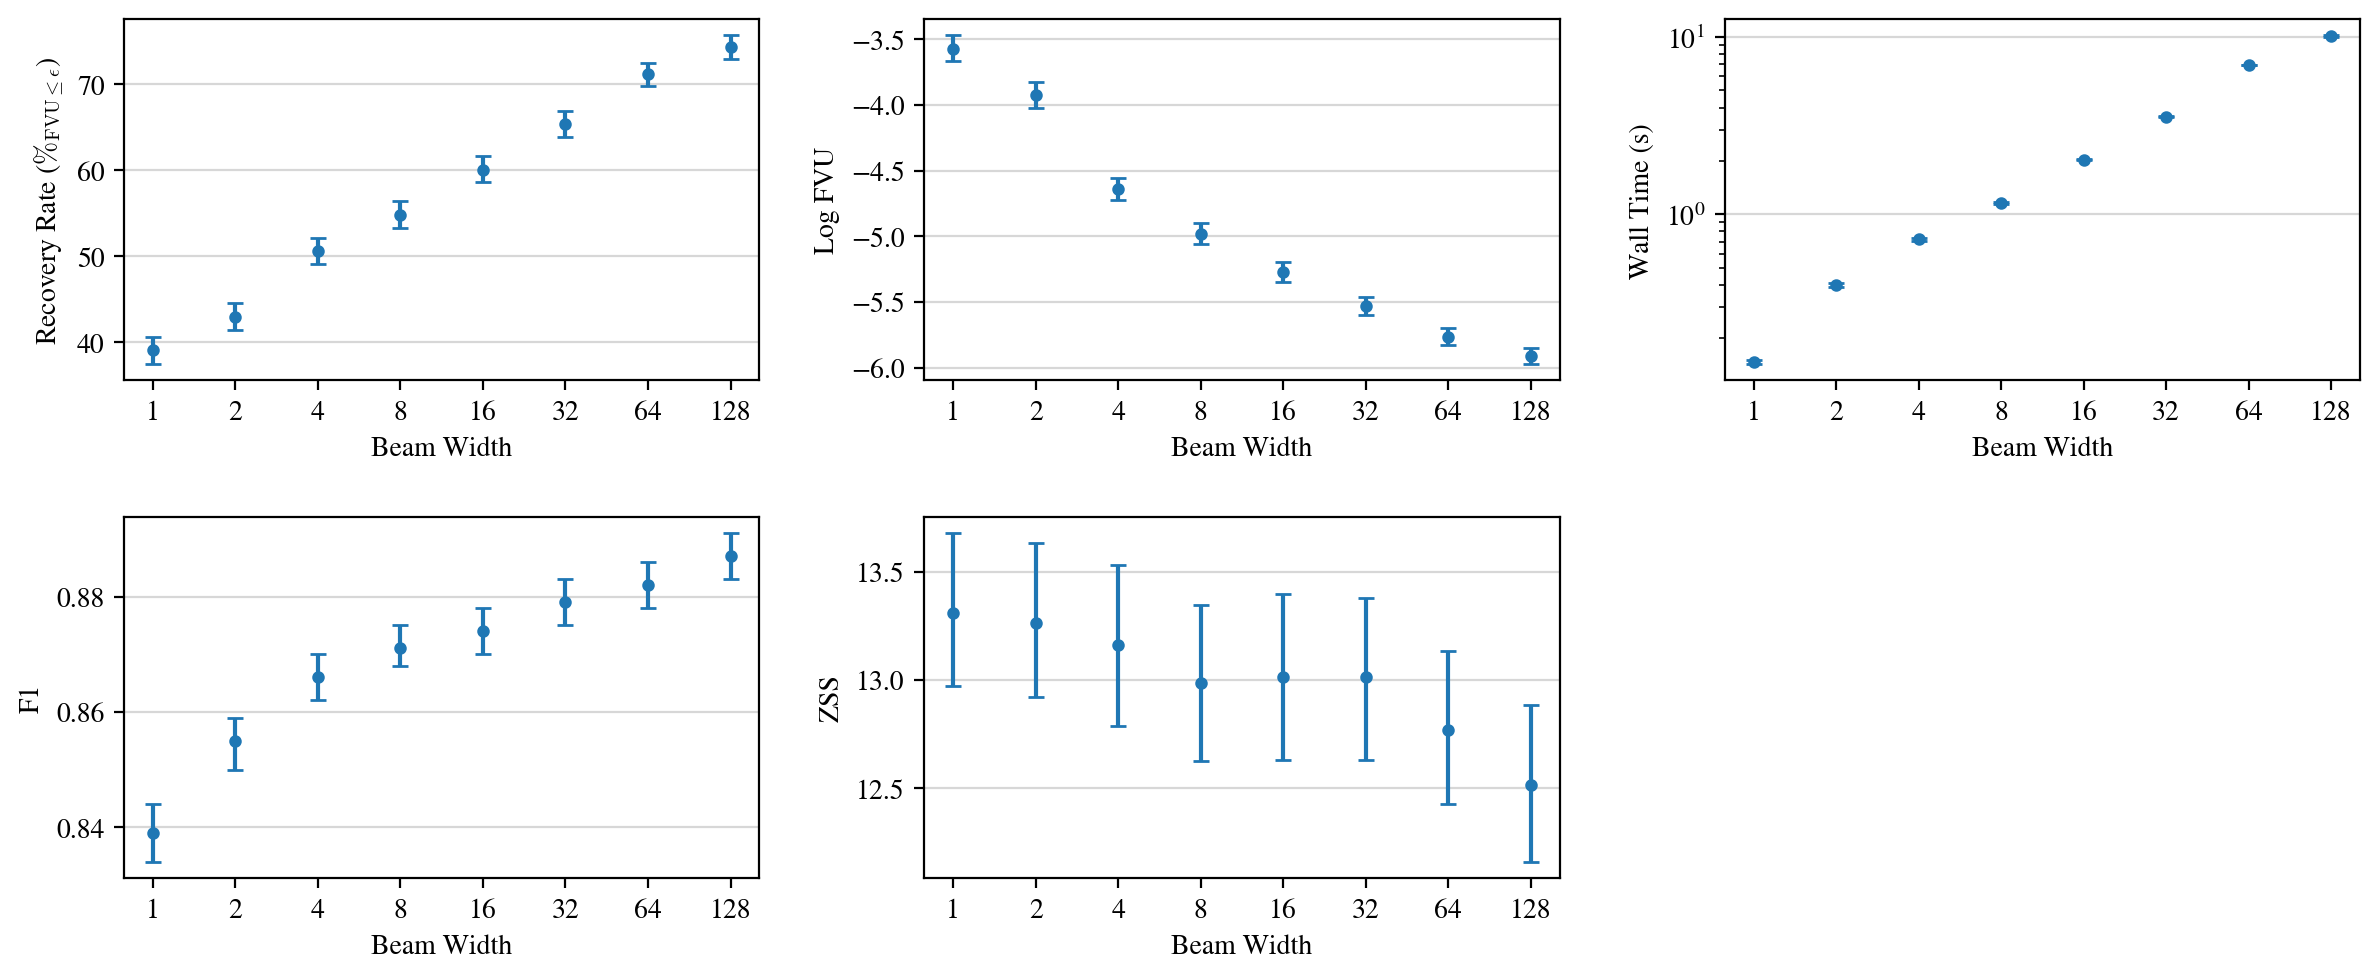

In [44]:
show_metric_list = ['FVU-eps_accuracy', 'log_fvu', 'wall_time', 'f1_score_best_beam', 'tree_edit_distance_best_beam']
y_label_list = ['Recovery Rate ($\%_{\\text{FVU} \leq \\epsilon}$)', 'Log FVU', 'Wall Time (s)', 'F1', 'ZSS']
sub_metric_list = ['mean', 'mean', 'mean', 'mean', 'mean']
factor_list = [100, 1, 1, 1, 1]
yscale_list = ['linear', 'linear', 'log', 'linear', 'linear']
# ylim_list = [(0, 100), (np.log10(np.finfo(np.float32).eps), None), (0, None), (0, 1), (0, None)]
ylim_list = [None] * len(show_metric_list)

x = [configs[model]['n_beams'] for model in MODELS]

COLS = min(3, len(show_metric_list))
ROWS = np.ceil(len(show_metric_list) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 4, ROWS * 2.5), dpi=200)

for i, (show_metric, sub_metric, ax, y_label, factor, ylim, yscale) in enumerate(zip(show_metric_list, sub_metric_list, axes.flatten(), y_label_list, factor_list, ylim_list, yscale_list)):
    y = total_summary_tables[sub_metric]['median'].T.loc[show_metric] * factor
    y_lower = total_summary_tables[sub_metric]['lower'].T.loc[show_metric] * factor
    y_upper = total_summary_tables[sub_metric]['upper'].T.loc[show_metric] * factor

    ax.errorbar(x, y, yerr=[y - y_lower, y_upper - y], fmt='.', markersize=7, capsize=3)
    ax.set_xscale('log', base=2)
    ax.set_yscale(yscale)
    ax.set_xticks(x)
    ax.set_xticklabels(x)

    ax.set_xlabel('Beam Width')
    ax.set_ylabel(y_label)
    ax.grid(alpha=0.5, axis='y')

    ax.set_ylim(ylim)

for ax in axes.flatten()[len(show_metric_list):]:
    ax.axis('off')

fig.tight_layout(w_pad=2, h_pad=2)

In [45]:
sub_metrics = ['mean', 'median', '2.5p', '97.5p']
sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]

total_summary_lengths = {length: {model: {column: {k: (np.nan, ) * 3 for k in sub_metrics} for column in compare_columns} for model in array_dfs.keys()} for length in range(32)}
aggregate_sets = ['feynman', 'soose_nc', 'nguyen', 'pool_15']
metrics = None

N_BOOTSTRAPS = 100

for model, model_dfs in array_dfs.items():
    if len(model_dfs) == 0:
        continue
    aggregated_data_lengths = {length: pd.concat([df[df['length_target'] == length] for test_set, df in model_dfs.items() if test_set in aggregate_sets]) for length in range(32)}

    for length in tqdm(range(32)):
        for column in compare_columns:
            if column in aggregated_data_lengths[length].columns:
                data = aggregated_data_lengths[length][column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
                total_summary_lengths[length][model][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}

    if metrics is None:
        metrics = total_summary_lengths[length][model][column].keys()

  0%|          | 0/32 [00:00<?, ?it/s]/tmp/ipykernel_2143/3880369273.py:2: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.array(x)[np.isfinite(x)])
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1649: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  9%|▉         | 3/32 [00:00<00:04,  7.00it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
 62%|██████▎   | 20/32 [00:08<00:05,  2.38it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4623: RuntimeWarning: invalid value encountered

In [46]:
total_summary_tables_length = {
    length: {
        metric: {
            percentile:
                pd.DataFrame({
                model: {
                    column: total_summary_lengths[length][model][column][metric][k]
                    for column in compare_columns}
                    for model in total_summary.keys()}).T.round(3)
                    for k, percentile in enumerate(['median', 'lower', 'upper'])}
                    for metric in metrics}
                    for length in range(32)}

In [47]:
from matplotlib.colors import LogNorm

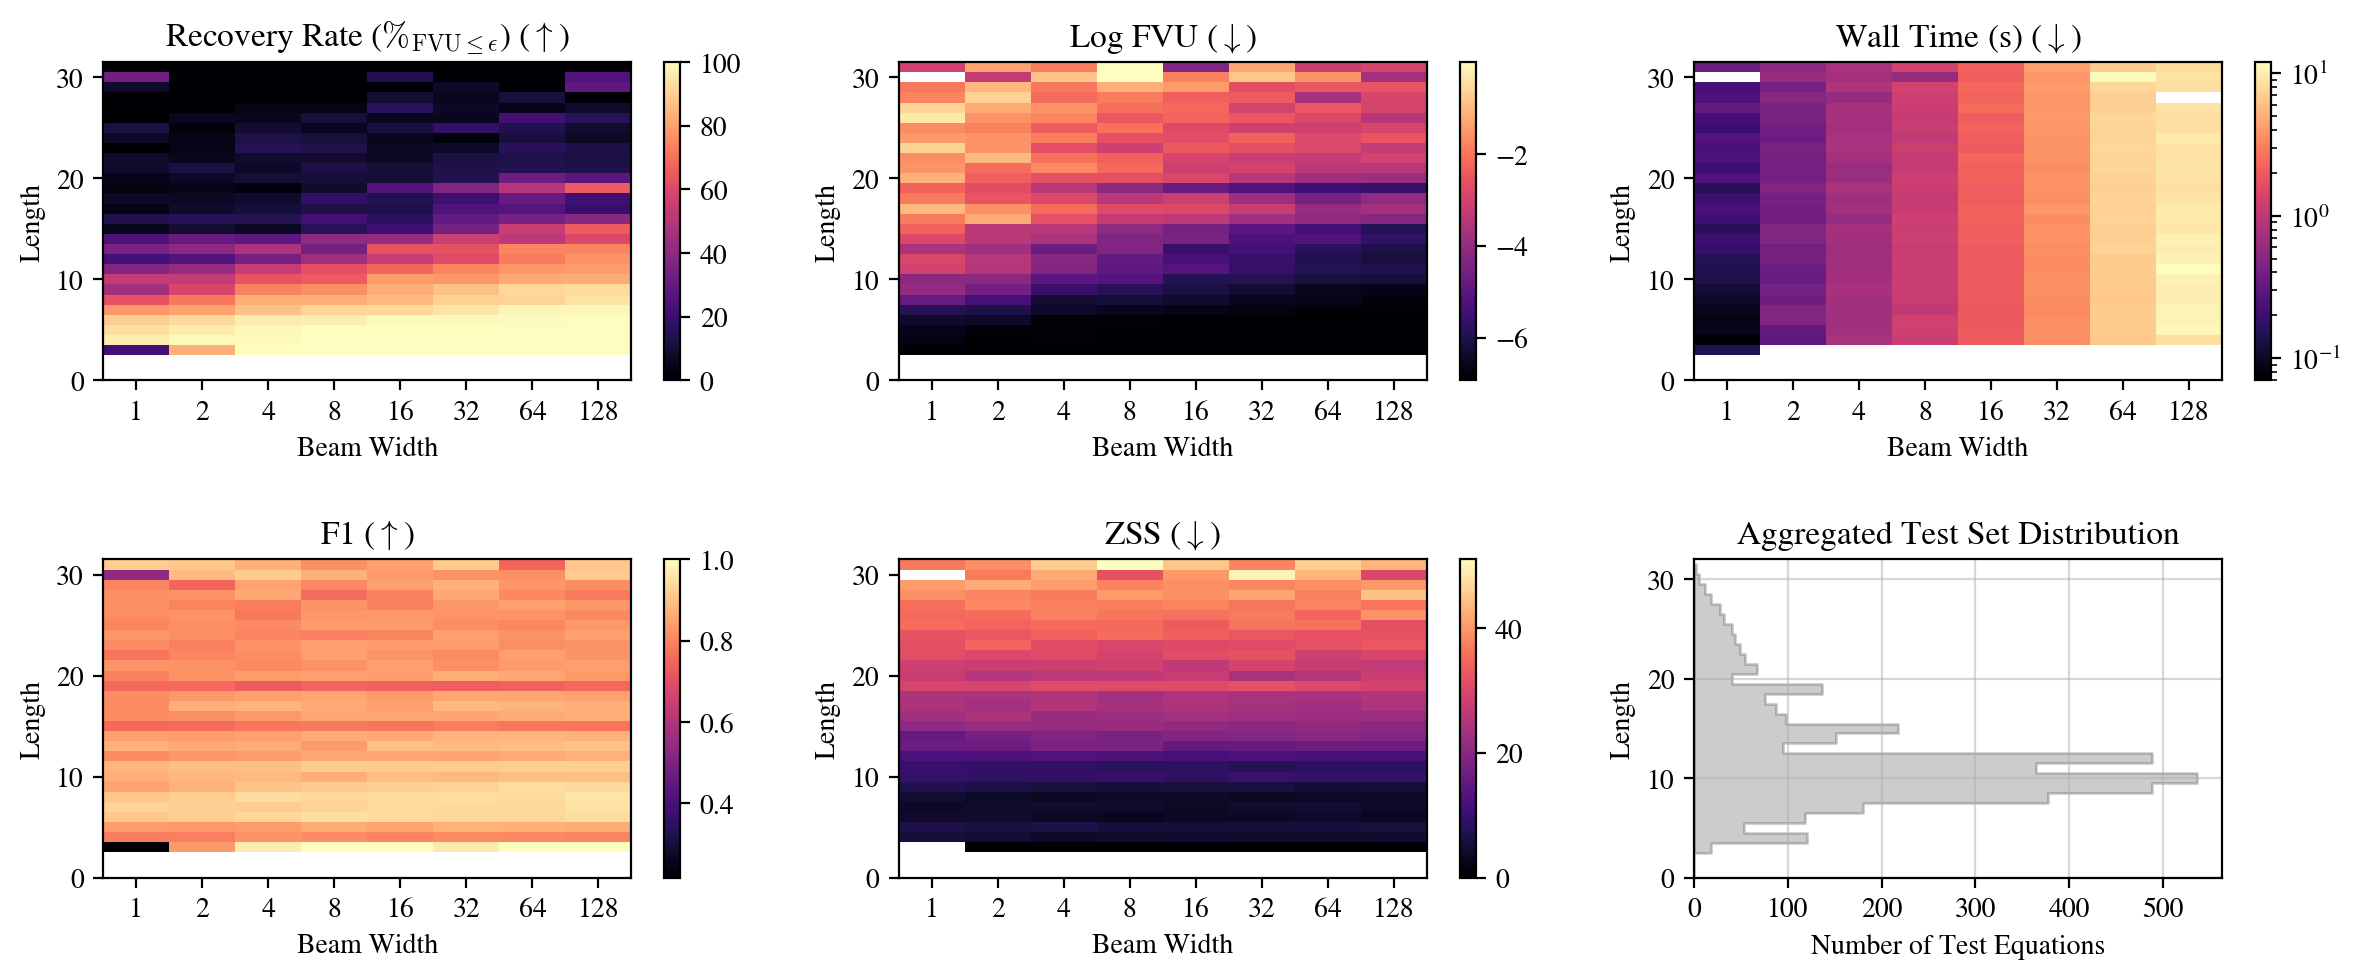

In [100]:
show_metric_list = ['FVU-eps_accuracy', 'log_fvu', 'wall_time', 'f1_score_best_beam', 'tree_edit_distance_best_beam']
objective_list = ['max', 'min', 'min', 'max', 'min']
y_label_list = ['Recovery Rate ($\%_{\\text{FVU} \leq \\epsilon}$)', 'Log FVU', 'Wall Time (s)', 'F1', 'ZSS']
sub_metric_list = ['mean', 'mean', 'mean', 'mean', 'mean']
factor_list = [100, 1, 1, 1, 1]
log_norm_list = [False, False, True, False, False]
# ylim_list = [(0, 100), (np.log10(np.finfo(np.float32).eps), None), (0, None), (0, 1), (0, None)]
ylim_list = [(0, 31.5)] * len(show_metric_list)

x = np.array([configs[model]['n_beams'] for model in MODELS])
sorted_indices = np.argsort(x)

COLS = min(3, len(show_metric_list))
ROWS = np.ceil(len(show_metric_list) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 4, ROWS * 2.5), dpi=200)

for i, (show_metric, sub_metric, ax, y_label, factor, ylim, log_norm, objective) in enumerate(zip(show_metric_list, sub_metric_list, axes.flatten(), y_label_list, factor_list, ylim_list, log_norm_list, objective_list)):
    y = np.array([s[sub_metric]['median'].T.loc[show_metric] for s in total_summary_tables_length.values()]) * factor

    mesh = np.meshgrid(np.log2(x[sorted_indices]), np.arange(32))
    colormesh = ax.pcolormesh(mesh[0], mesh[1], y[:, sorted_indices], shading='auto', cmap='magma', norm=LogNorm() if log_norm else None)

    ax.set_xticks(np.log2(x))
    ax.set_xticklabels(x)

    ax.set_ylabel('Length')
    ax.set_xlabel('Beam Width')
    arrow = '$\\uparrow$' if objective == 'max' else '$\\downarrow$'
    ax.set_title(y_label + f' ({arrow})')
    
    # Add a little colorbar to each plot
    cb = plt.colorbar(colormesh, ax=ax)

    ax.set_ylim(ylim)

hist_x = np.arange(32)
hist_y = [len(aggregated_data_lengths[length]) for length in range(32)]

hist_plot_x = np.empty(2 * len(hist_x))
hist_plot_x[0::2] = hist_x - 0.5
hist_plot_x[1::2] = hist_x + 0.5
hist_plot_y = np.empty(2 * len(hist_y))
hist_plot_y[0::2] = hist_y
hist_plot_y[1::2] = hist_y

axes.flatten()[-1].fill_betweenx(hist_plot_x, hist_plot_y, color='k', alpha=0.2)
axes.flatten()[-1].set_xlim(0, None)
axes.flatten()[-1].set_xlabel('Number of Test Equations')
axes.flatten()[-1].set_ylabel('Length')
axes.flatten()[-1].grid(alpha=0.5)
axes.flatten()[-1].set_ylim(0, 32)
axes.flatten()[-1].set_title('Aggregated Test Set Distribution')

# Add a phantom colorbar
cb = plt.colorbar(colormesh, ax=axes.flatten()[-1])
# Hide the colorbar
cb.ax.set_visible(False)

fig.tight_layout(w_pad=2, h_pad=2)

In [44]:
def int_to_10(i, theshold=100):
    if i > theshold:
        return '$10^{' + f'{np.log10(i):.0f}' + '}$'
    elif i < 1 / theshold:
        return '$10^{-' + f'{np.log10(1/i):.0f}' + '}$'
    return str(i)

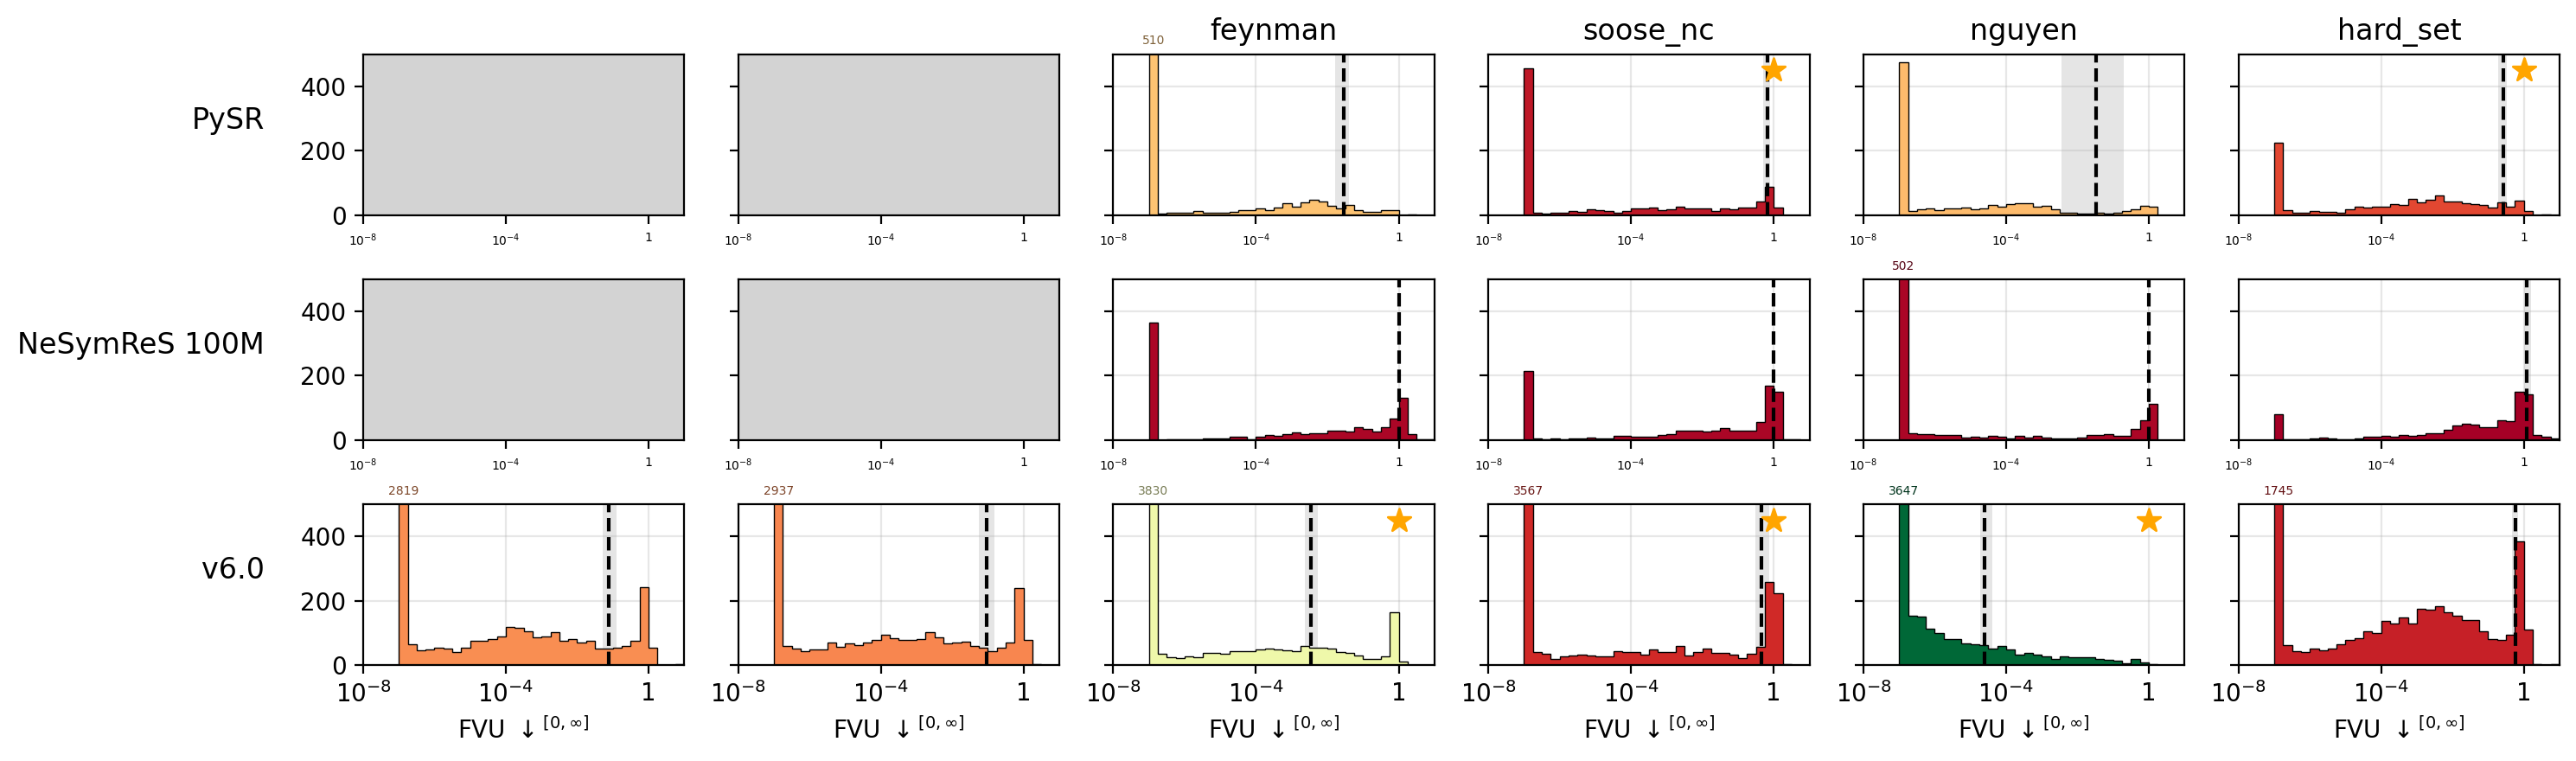

In [45]:
ROWS = len(MODELS)
# COLS = max(len(model_test_sets) for model_test_sets in test_sets.values())
COLS = len(TEST_SETS)
N_BOOTSTRAPS = 1_000

fig, axes = plt.subplots(ROWS, COLS, figsize=(2.5 * COLS, 1.5 * ROWS), sharey=True, dpi=200)

axes = np.atleast_2d(axes)

xlim = (-8, 1)
bins = np.linspace(*xlim, (xlim[1] - xlim[0]) * 4 + 1)
# ylim = (0, 1.05 * max([max(np.histogram(array_dfs[model][test_set]['log_fvu'], bins=bins)[0]) for model in MODELS for test_set in test_sets[model]]))
ylim = (0, 500)

# Plot the distributions of a given metric for each model and test set
metric_name = 'log_fvu'

def stats_from_log_values(statistic):
    return lambda x: np.log(statistic(np.power(10, x)) + np.finfo(float).eps)

color_metric = lambda x: np.percentile(x[~np.isnan(x)], 90)

min_color_metric = np.min([np.min([color_metric(array_dfs[model][test_set][metric_name].replace(np.nan, 0).replace(np.inf, np.nan)) for test_set in test_sets[model] if test_set in array_dfs[model].keys()]) for model in MODELS])
max_color_metric = np.max([np.max([color_metric(array_dfs[model][test_set][metric_name].replace(np.nan, 0).replace(np.inf, np.nan)) for test_set in test_sets[model] if test_set in array_dfs[model].keys()]) for model in MODELS])

highest_lower_confidence_bound = {test_set: (None, np.inf) for test_set in TEST_SETS}

for i, model in enumerate(MODELS):
    for j, test_set in enumerate(TEST_SETS):
        ax = axes[i, j]
        ax.set_xticks([-8, -4, 0])
        ax.set_xticklabels([int_to_10(10**i) for i in [ -8, -4, 0]], fontdict={'fontsize': 5 if i != len(MODELS) - 1 else 10})
        if j == 0: ax.set_ylabel(MODELS_DESCRIPTION[model], rotation=0, labelpad=15, ha='right', fontsize=12)
        if i == len(MODELS) - 1: ax.set_xlabel(r'$\text{FVU}\,\,\downarrow^{[0, \infty]}$')
        if test_set not in array_dfs[model]:
            ax.set_xlim(xlim)
            ax.set_facecolor('lightgrey')
            continue
        data = array_dfs[model][test_set][metric_name].replace(np.nan, 0).replace(np.inf, np.nan).values

        color = plt.get_cmap('RdYlGn').reversed()((color_metric(data) - min_color_metric) / (max_color_metric - min_color_metric))

        ax.hist(data, bins=bins, color=color, zorder=2)
        ax.hist(data, bins=bins, zorder=2, histtype='step', edgecolor='k', linewidth=0.5)

        hist, bin_edges = np.histogram(data, bins=bins)
        for h, mid in zip(hist, (bin_edges[1:] + bin_edges[:-1]) / 2):
            if h > ylim[1]:
                ax.annotate(f'{h}', xy=(mid, ylim[1]), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=5, color=tuple(np.array(color)[:3] * 0.5) + (1,))

        median_median, median_5, median_95 = bootstrapped_metric_ci(data, color_metric, n=N_BOOTSTRAPS)

        if median_5 < highest_lower_confidence_bound[test_set][1]:
            highest_lower_confidence_bound[test_set] = (model, median_95)

        ax.axvline(median_median, color='black', linestyle='--', zorder=3)
        # ax.errorbar(median_median, ylim[1], xerr=[[median_median - median_5], [median_95 - median_median]], fmt='.', color='black', zorder=4, capsize=3, markersize=0, clip_on=True)
        ax.axvspan(median_5, median_95, color='black', alpha=0.1, zorder=1, linewidth=0)
        ax.set_ylim(ylim)
        ax.grid(alpha=0.3, zorder=0)
        if i == 0: ax.set_title(test_set)
        ax.set_xlim(xlim)

within_lowest_upper_confidence_bound = {test_set: [] for test_set in TEST_SETS}
for i, model in enumerate(MODELS):
    for j, test_set in enumerate(TEST_SETS):
        if test_set not in array_dfs[model]:
            continue
        data = array_dfs[model][test_set][metric_name].replace(np.nan, 0).replace(np.inf, np.nan).values
        median_median, median_5, median_95 = bootstrapped_metric_ci(data, color_metric, n=N_BOOTSTRAPS)

        if median_5 < highest_lower_confidence_bound[test_set][1]:
            within_lowest_upper_confidence_bound[test_set].append(model)

# For each test set, mark the model (row) with the lowest median log_fvu
for j, test_set in enumerate(TEST_SETS):
    if test_set in ['train', 'val']:
        continue
    models = within_lowest_upper_confidence_bound[test_set]
    for i, model in enumerate(MODELS):
        if model in models:
            axes[MODELS.index(model), j].scatter([0], [ylim[1] * 0.9], color='orange', marker='*', s=100, zorder=5)

fig.tight_layout(h_pad=0.5)

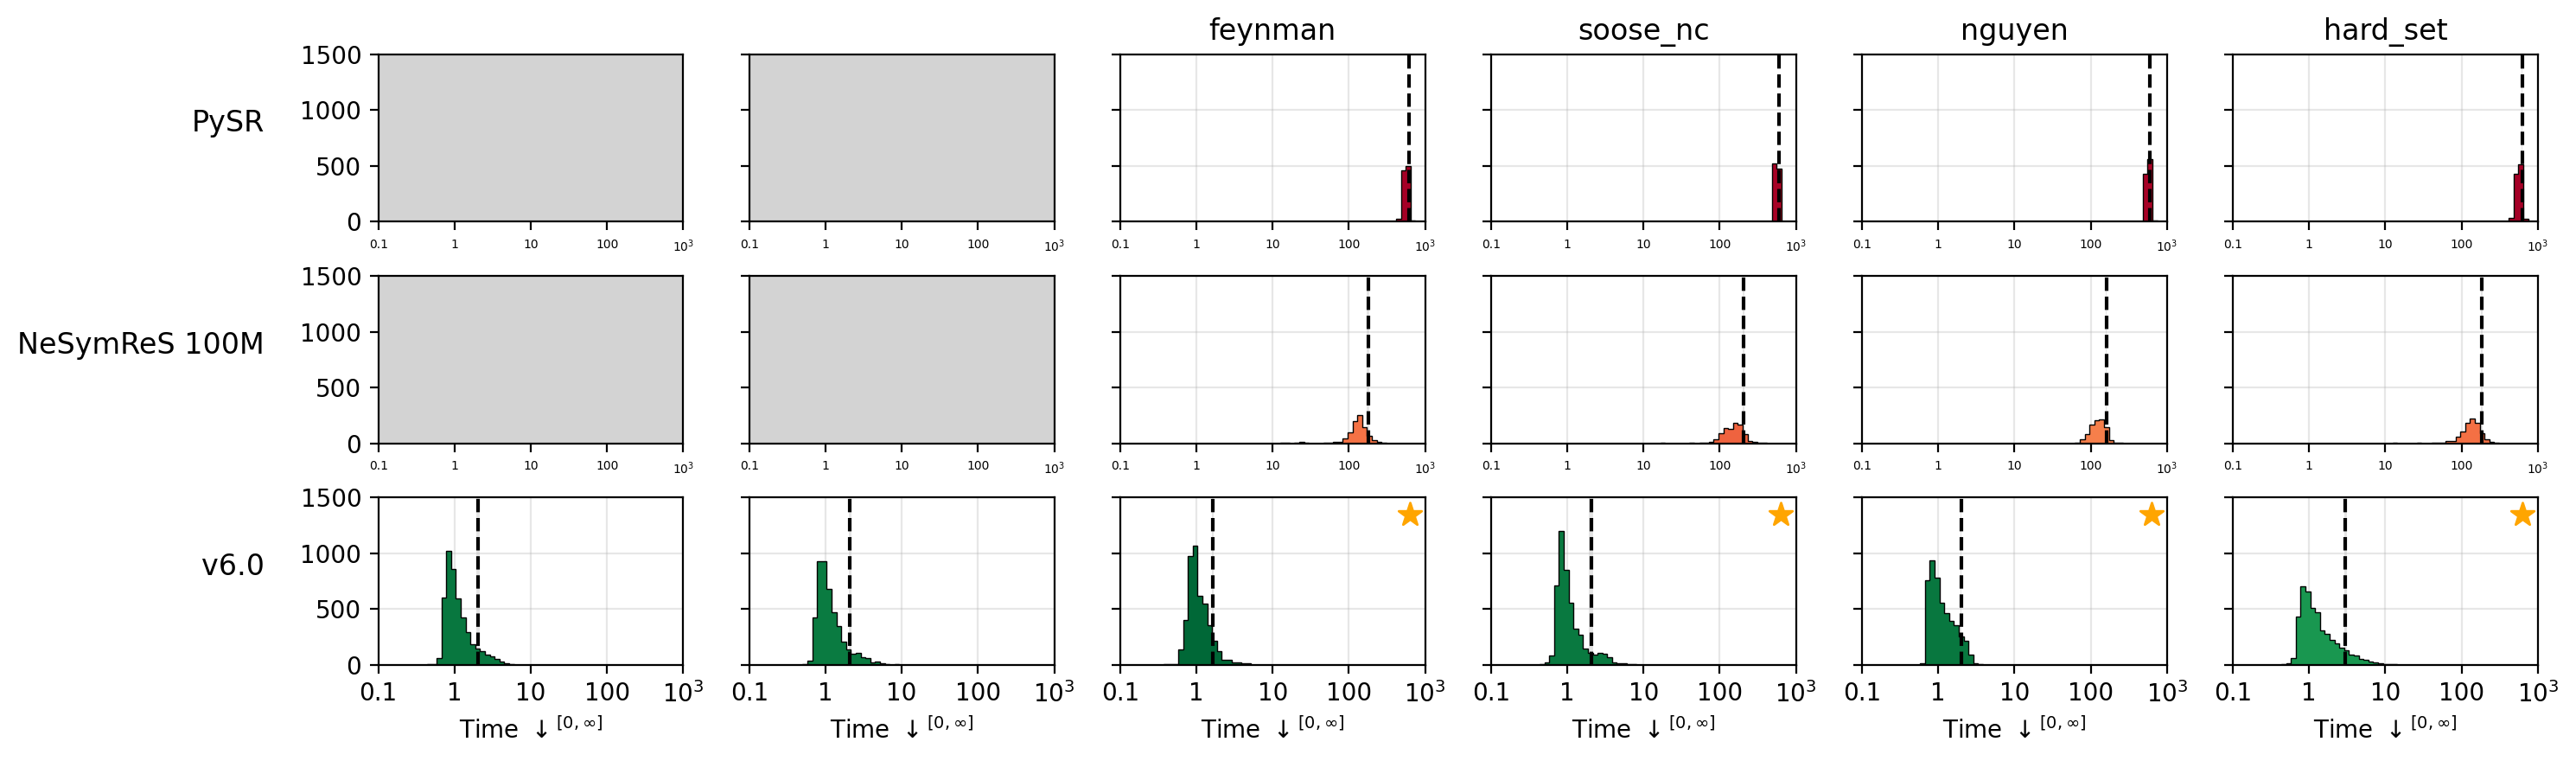

In [46]:
ROWS = len(MODELS)
# COLS = max(len(model_test_sets) for model_test_sets in test_sets.values())
COLS = len(TEST_SETS)
N_BOOTSTRAPS = 1_000

fig, axes = plt.subplots(ROWS, COLS, figsize=(2.5 * COLS, 1.5 * ROWS), sharey=True, dpi=200)

axes = np.atleast_2d(axes)

xlim = (-1, 3)
bins = np.linspace(*xlim, 64)
# ylim = (0, 1.05 * max([max(np.histogram(array_dfs[model][test_set]['log_fvu'], bins=bins)[0]) for model in MODELS for test_set in test_sets[model]]))
ylim = (0, 1500)

# Plot the distributions of a given metric for each model and test set
metric_name = 'sys_time'

color_metric = lambda x: np.percentile(x[~np.isnan(x) & ~np.isinf(x)], 90)

min_color_metric = np.min([np.min([color_metric(np.log10(array_dfs[model][test_set][metric_name].replace(np.inf, np.nan))) for test_set in test_sets[model] if test_set in array_dfs[model].keys()]) for model in MODELS])
max_color_metric = np.max([np.max([color_metric(np.log10(array_dfs[model][test_set][metric_name].replace(np.inf, np.nan))) for test_set in test_sets[model] if test_set in array_dfs[model].keys()]) for model in MODELS])

highest_lower_confidence_bound = {test_set: (None, np.inf) for test_set in TEST_SETS}

for i, model in enumerate(MODELS):
    for j, test_set in enumerate(TEST_SETS):
        ax = axes[i, j]
        ax.set_xticks([-1, 0, 1, 2, 3])
        ax.set_xticklabels([int_to_10(10**i) for i in [-1, 0, 1, 2, 3]], fontdict={'fontsize': 5 if i != len(MODELS) - 1 else 10})
        if j == 0: ax.set_ylabel(MODELS_DESCRIPTION[model], rotation=0, labelpad=15, ha='right', fontsize=12)
        if i == len(MODELS) - 1: ax.set_xlabel(r'$\text{Time}\,\,\downarrow^{[0, \infty]}$')
        if test_set not in array_dfs[model]:
            ax.set_xlim(xlim)
            ax.set_facecolor('lightgrey')
            continue
        data = np.log10(array_dfs[model][test_set][metric_name].replace(np.inf, np.nan).values)

        color = plt.get_cmap('RdYlGn').reversed()((color_metric(data) - min_color_metric) / (max_color_metric - min_color_metric))

        ax.hist(data, bins=bins, color=color, zorder=2)
        ax.hist(data, bins=bins, zorder=2, histtype='step', edgecolor='k', linewidth=0.5)

        hist, bin_edges = np.histogram(data, bins=bins)
        for h, mid in zip(hist, (bin_edges[1:] + bin_edges[:-1]) / 2):
            if h > ylim[1]:
                ax.annotate(f'{h}', xy=(mid, ylim[1]), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=5, color=tuple(np.array(color)[:3] * 0.5) + (1,))

        median_median, median_5, median_95 = bootstrapped_metric_ci(data, color_metric, n=N_BOOTSTRAPS)

        if median_5 < highest_lower_confidence_bound[test_set][1]:
            highest_lower_confidence_bound[test_set] = (model, median_95)

        ax.axvline(median_median, color='black', linestyle='--', zorder=3)
        # ax.errorbar(median_median, ylim[1], xerr=[[median_median - median_5], [median_95 - median_median]], fmt='.', color='black', zorder=4, capsize=3, markersize=0, clip_on=True)
        ax.axvspan(median_5, median_95, color='black', alpha=0.1, zorder=1, linewidth=0)
        ax.set_ylim(ylim)
        ax.grid(alpha=0.3, zorder=0)
        if i == 0: ax.set_title(test_set)
        ax.set_xlim(xlim)

within_lowest_upper_confidence_bound = {test_set: [] for test_set in TEST_SETS}
for i, model in enumerate(MODELS):
    for j, test_set in enumerate(TEST_SETS):
        if test_set not in array_dfs[model]:
            continue
        data = np.log10(array_dfs[model][test_set][metric_name].replace(np.inf, np.nan).values)
        median_median, median_5, median_95 = bootstrapped_metric_ci(data, color_metric, n=N_BOOTSTRAPS)

        if median_5 < highest_lower_confidence_bound[test_set][1]:
            within_lowest_upper_confidence_bound[test_set].append(model)

# For each test set, mark the model (row) with the lowest median log_fvu
for j, test_set in enumerate(TEST_SETS):
    if test_set in ['train', 'val']:
        continue
    models = within_lowest_upper_confidence_bound[test_set]
    for i, model in enumerate(MODELS):
        if model in models:
            axes[MODELS.index(model), j].scatter([2.8], [ylim[1] * 0.9], color='orange', marker='*', s=100, zorder=5)

fig.tight_layout(h_pad=0.5)

In [47]:
# from nsr import ExpressionSpace, get_path
# space = ExpressionSpace.from_config(get_path('configs/v4.2/expression_space.yaml'))
# from itertools import groupby
# from collections import Counter

In [48]:
# lists = {model: {model_test_set: space.tokenizer.decode(results[model][model_test_set]['data']['labels']) for model_test_set in results[model].keys()} for model in MODELS for test_set in TEST_SETS}
# splits = {model: {model_test_set: [tuple(y) for x, y in groupby(lst, lambda z: z == '<eos>') if not x] for model_test_set, lst in v.items()} for model, v in lists.items()}

In [49]:
# test_set_labels_union = {test_set: set.union(*[set([tuple(x) for x in splits[model].get(test_set, [])]) for model in MODELS]) for test_set in TEST_SETS}

# for k, v in test_set_labels_union.items():
#     print(k, len(v))

In [50]:
# eq_data = {model: {test_set: {k: [array_dfs[model][test_set]['log_fvu'][i] for i in range(len(array_dfs[model][test_set]['log_fvu'])) if splits[model][test_set][i] == k] for k in test_set_labels_union[test_set]} for test_set in TEST_SETS if test_set in array_dfs[model].keys()} for model in MODELS}

In [51]:
# # For each unique sequence, plot how often it appears in the test set
# fig, axes = plt.subplots(1, 2, figsize=(7, 3.2), dpi=200)

# compare_models = ['v4.2', 'v4.10']
# compare_test_set = 'soose_nc'

# max_count = max([max(Counter(splits[model][compare_test_set]).values()) for model in compare_models])

# counter_1 = Counter(splits[compare_models[0]][compare_test_set])
# counter_2 = Counter(splits[compare_models[1]][compare_test_set])

# axes[0].hist2d([counter_1.get(k, 0) for k in test_set_labels_union[compare_test_set]], [counter_2.get(k, 0) for k in test_set_labels_union[compare_test_set]], bins=range(0, max_count + 1), cmap='viridis')
# axes[0].set_xticks(0.5 + np.linspace(0, max_count + 1, 5)[:-1])
# axes[0].set_yticks(0.5 + np.linspace(0, max_count + 1, 5)[:-1])
# axes[0].set_xticklabels(np.linspace(0, max_count, 5, dtype=int)[:-1])
# axes[0].set_yticklabels(np.linspace(0, max_count, 5, dtype=int)[:-1])
# axes[0].set_xlabel(f'{compare_models[0]} count')
# axes[0].set_ylabel(f'{compare_models[1]} count')

# data = pd.DataFrame({
#     compare_models[0]: [np.nanmedian(eq_data[compare_models[0]][compare_test_set][k]) for k in test_set_labels_union[compare_test_set]],
#     compare_models[1]: [np.nanmedian(eq_data[compare_models[1]][compare_test_set][k]) for k in test_set_labels_union[compare_test_set]],
#     'count': [len(eq_data[compare_models[0]][compare_test_set][k]) for k in test_set_labels_union[compare_test_set]],
# })

# axes[1].scatter(data[compare_models[0]], data[compare_models[1]], alpha=0.5, s=data['count'] * 2)
# axes[1].set_xlim(-17, 1)
# axes[1].set_ylim(-17, 1)
# axes[1].set_xticks([-16, -12, -8, -4, 0])
# axes[1].set_yticks([-16, -12, -8, -4, 0])
# axes[1].set_xlabel(f'{compare_models[0]} log FVU')
# axes[1].set_ylabel(f'{compare_models[1]} log FVU')

# fig.tight_layout(w_pad=3)

In [52]:
# sorted(results['v4.2']['soose_nc']['data']['log_fvu'])[:10]

In [53]:
# sorted(results['v4.10']['soose_nc']['data']['log_fvu'])[:10]

In [54]:
# # Show the 10 easiest equations of 'v4.2' measured by log FVU
# easy2 = sorted([(k, np.nanmean(v), len(v)) for k, v in eq_data['v4.2']['soose_nc'].items()], key=lambda x: x[1] if not np.isnan(x[1]) else np.inf)[:20]

# for k, v, l in easy2:
#     print(f'{space.prefix_to_infix(k):<50} {v:>6.2f} ({l}) {np.nanmean(eq_data["v4.10"]["soose_nc"].get(k, [])):>6.2f} ({len(eq_data["v4.10"]["soose_nc"].get(k, []))})')

In [55]:
UNIQUE_MODELS_NO_NESYMRES = [m for m in UNIQUE_MODELS if m != 'nesymres-100M']

/tmp/ipykernel_27333/3817520256.py:15: RuntimeWarning: Mean of empty slice
  min_color_metric = np.nanmin([np.nanmin([color_metric(array_dfs[model][test_set].get(metric_name, pd.Series([np.nan]))) for test_set in test_sets[model]]) for model in UNIQUE_MODELS_NO_NESYMRES])
/tmp/ipykernel_27333/3817520256.py:15: RuntimeWarning: All-NaN axis encountered
  min_color_metric = np.nanmin([np.nanmin([color_metric(array_dfs[model][test_set].get(metric_name, pd.Series([np.nan]))) for test_set in test_sets[model]]) for model in UNIQUE_MODELS_NO_NESYMRES])
/tmp/ipykernel_27333/3817520256.py:16: RuntimeWarning: Mean of empty slice
  max_color_metric = np.nanmax([np.nanmax([color_metric(array_dfs[model][test_set].get(metric_name, pd.Series([np.nan]))) for test_set in test_sets[model]]) for model in UNIQUE_MODELS_NO_NESYMRES])
/tmp/ipykernel_27333/3817520256.py:16: RuntimeWarning: All-NaN axis encountered
  max_color_metric = np.nanmax([np.nanmax([color_metric(array_dfs[model][test_set].get(metric_na

ValueError: Cannot index with multidimensional key

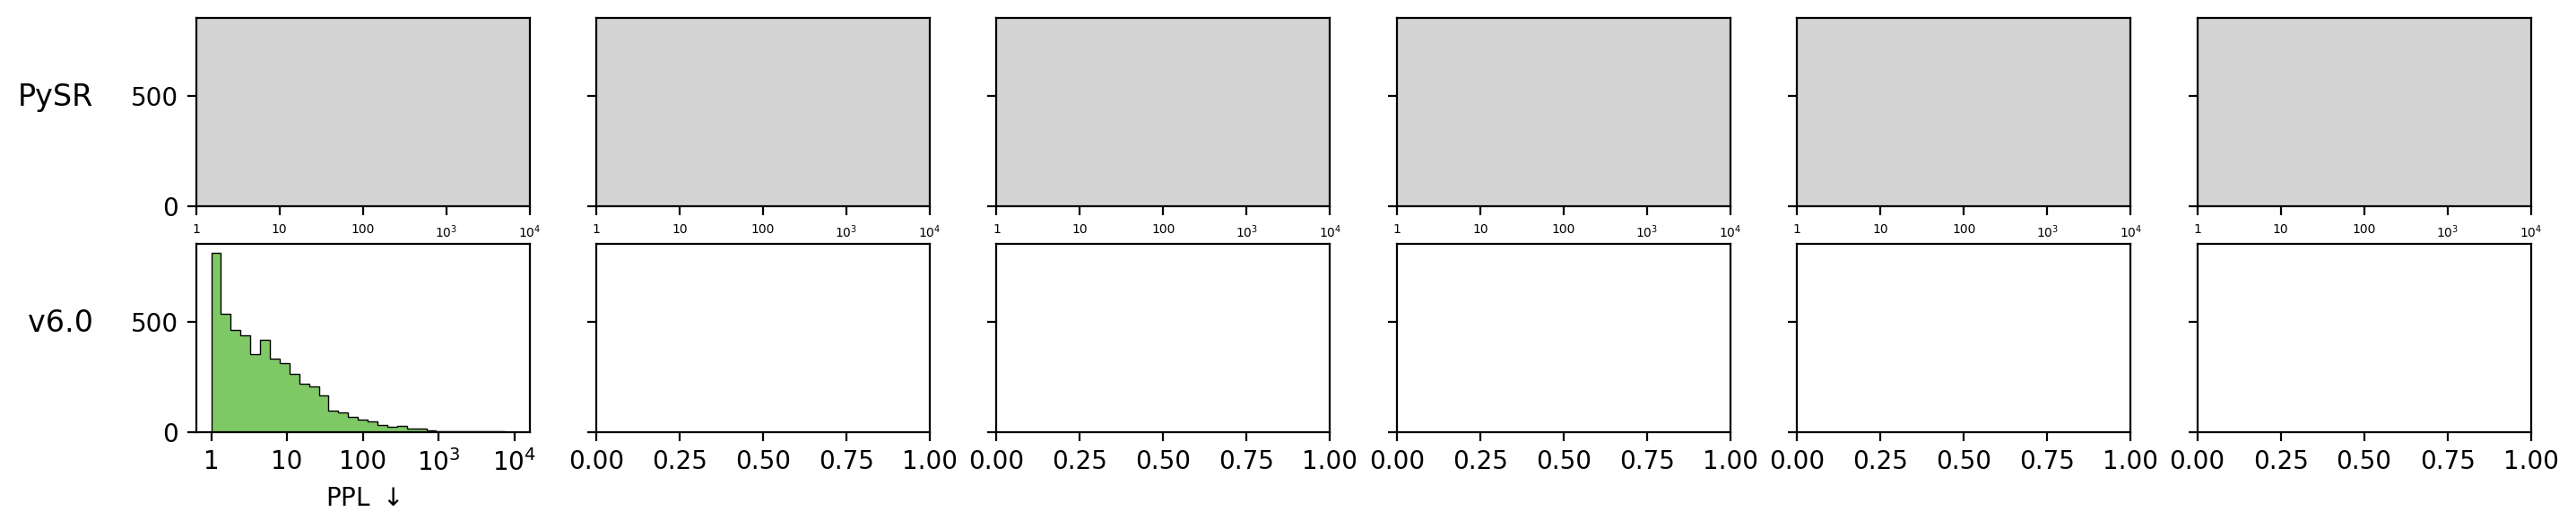

In [56]:
ROWS = len(UNIQUE_MODELS_NO_NESYMRES)
# COLS = max(len(model_test_sets) for model_test_sets in test_sets.values())
COLS = len(TEST_SETS)
fig, axes = plt.subplots(ROWS, COLS, figsize=(2.8 * COLS, 1.5 * ROWS), sharey=True, dpi=200)

metric_name = 'log_ppl'

xlim = (0, 4)
bins = np.linspace(*xlim, 32)
ylim = (0, 1.05 * max([max(np.histogram(array_dfs[model][test_set].get(metric_name, np.array([np.nan])), bins=bins)[0]) for model in UNIQUE_MODELS_NO_NESYMRES for test_set in test_sets[model]]))

# Plot the distributions of a given metric for each model and test set
color_metric = np.nanmean

min_color_metric = np.nanmin([np.nanmin([color_metric(array_dfs[model][test_set].get(metric_name, pd.Series([np.nan]))) for test_set in test_sets[model]]) for model in UNIQUE_MODELS_NO_NESYMRES])
max_color_metric = np.nanmax([np.nanmax([color_metric(array_dfs[model][test_set].get(metric_name, pd.Series([np.nan]))) for test_set in test_sets[model]]) for model in UNIQUE_MODELS_NO_NESYMRES])

highest_lower_confidence_bound = {test_set: (None, np.inf) for test_set in TEST_SETS}

for i, model in enumerate(UNIQUE_MODELS_NO_NESYMRES):
    for j, test_set in enumerate(TEST_SETS):
        ax = axes[i, j]
        ax.set_xticks(range(xlim[0], xlim[1] + 1))
        ax.set_xticklabels([int_to_10(10**i) for i in range(xlim[0], xlim[1] + 1)], fontdict={'fontsize': 5 if i != len(UNIQUE_MODELS_NO_NESYMRES) - 1 else 10})
        if j == 0: ax.set_ylabel(MODELS_DESCRIPTION[model], rotation=0, labelpad=15, ha='right', fontsize=12)
        if i == len(UNIQUE_MODELS_NO_NESYMRES) - 1: ax.set_xlabel(r'$\text{PPL}\,\,\downarrow$')
        if test_set not in array_dfs[model] or metric_name not in array_dfs[model][test_set] or array_dfs[model][test_set][metric_name].isnull().all():
            ax.set_xlim(xlim)
            ax.set_facecolor('lightgrey')
            continue
        data = array_dfs[model][test_set].get(metric_name, pd.Series([np.nan])).replace(np.nan, np.inf)
        ax.hist(data, bins=bins, color=plt.get_cmap('RdYlGn').reversed()((color_metric(data) - min_color_metric) / (max_color_metric - min_color_metric)), zorder=2)
        ax.hist(data, bins=bins, zorder=2, histtype='step', edgecolor='k', linewidth=0.5)

        median_median, median_5, median_95 = bootstrapped_metric_ci(data, np.nanmean)

        if median_5 < highest_lower_confidence_bound[test_set][1]:
            highest_lower_confidence_bound[test_set] = (model, median_95)

        ax.axvline(median_median, color='black', linestyle='--', zorder=3)
        # ax.errorbar(median_median, ylim[1], xerr=[[median_median - median_5], [median_95 - median_median]], fmt='.', color='black', zorder=4, capsize=3, markersize=0, clip_on=True)
        ax.axvspan(median_5, median_95, color='black', alpha=0.1, zorder=1, linewidth=0)
        ax.set_ylim(ylim)
        ax.grid(alpha=0.3, zorder=0)
        if i == 0: ax.set_title(test_set)
        ax.set_xlim(xlim)


within_lowest_upper_confidence_bound = {test_set: [] for test_set in TEST_SETS}
for i, model in enumerate(UNIQUE_MODELS_NO_NESYMRES):
    for j, test_set in enumerate(TEST_SETS):
        if test_set not in array_dfs[model]:
            continue
        data = array_dfs[model][test_set].get(metric_name, pd.Series([np.nan])).replace(np.nan, np.inf)
        median_median, median_5, median_95 = bootstrapped_metric_ci(data, np.nanmean)

        if median_5 < highest_lower_confidence_bound[test_set][1]:
            within_lowest_upper_confidence_bound[test_set].append(model)

# For each test set, mark the model (row) with the lowest median log_fvu
for j, test_set in enumerate(TEST_SETS):
    if test_set in ['train', 'val']:
        continue
    models = within_lowest_upper_confidence_bound[test_set]
    for i, model in enumerate(UNIQUE_MODELS_NO_NESYMRES):
        if model in models:
            axes[UNIQUE_MODELS_NO_NESYMRES.index(model), j].scatter([xlim[1] * 0.95], [ylim[1] * 0.9], color='orange', marker='*', s=100, zorder=5)

fig.tight_layout(h_pad=0)

In [ ]:
MODELS_WITH_BEAMS = [model for model in MODELS if any('beam_2' in k for k in results[model]['feynman']['data'].keys())]

KeyError: 'feynman'

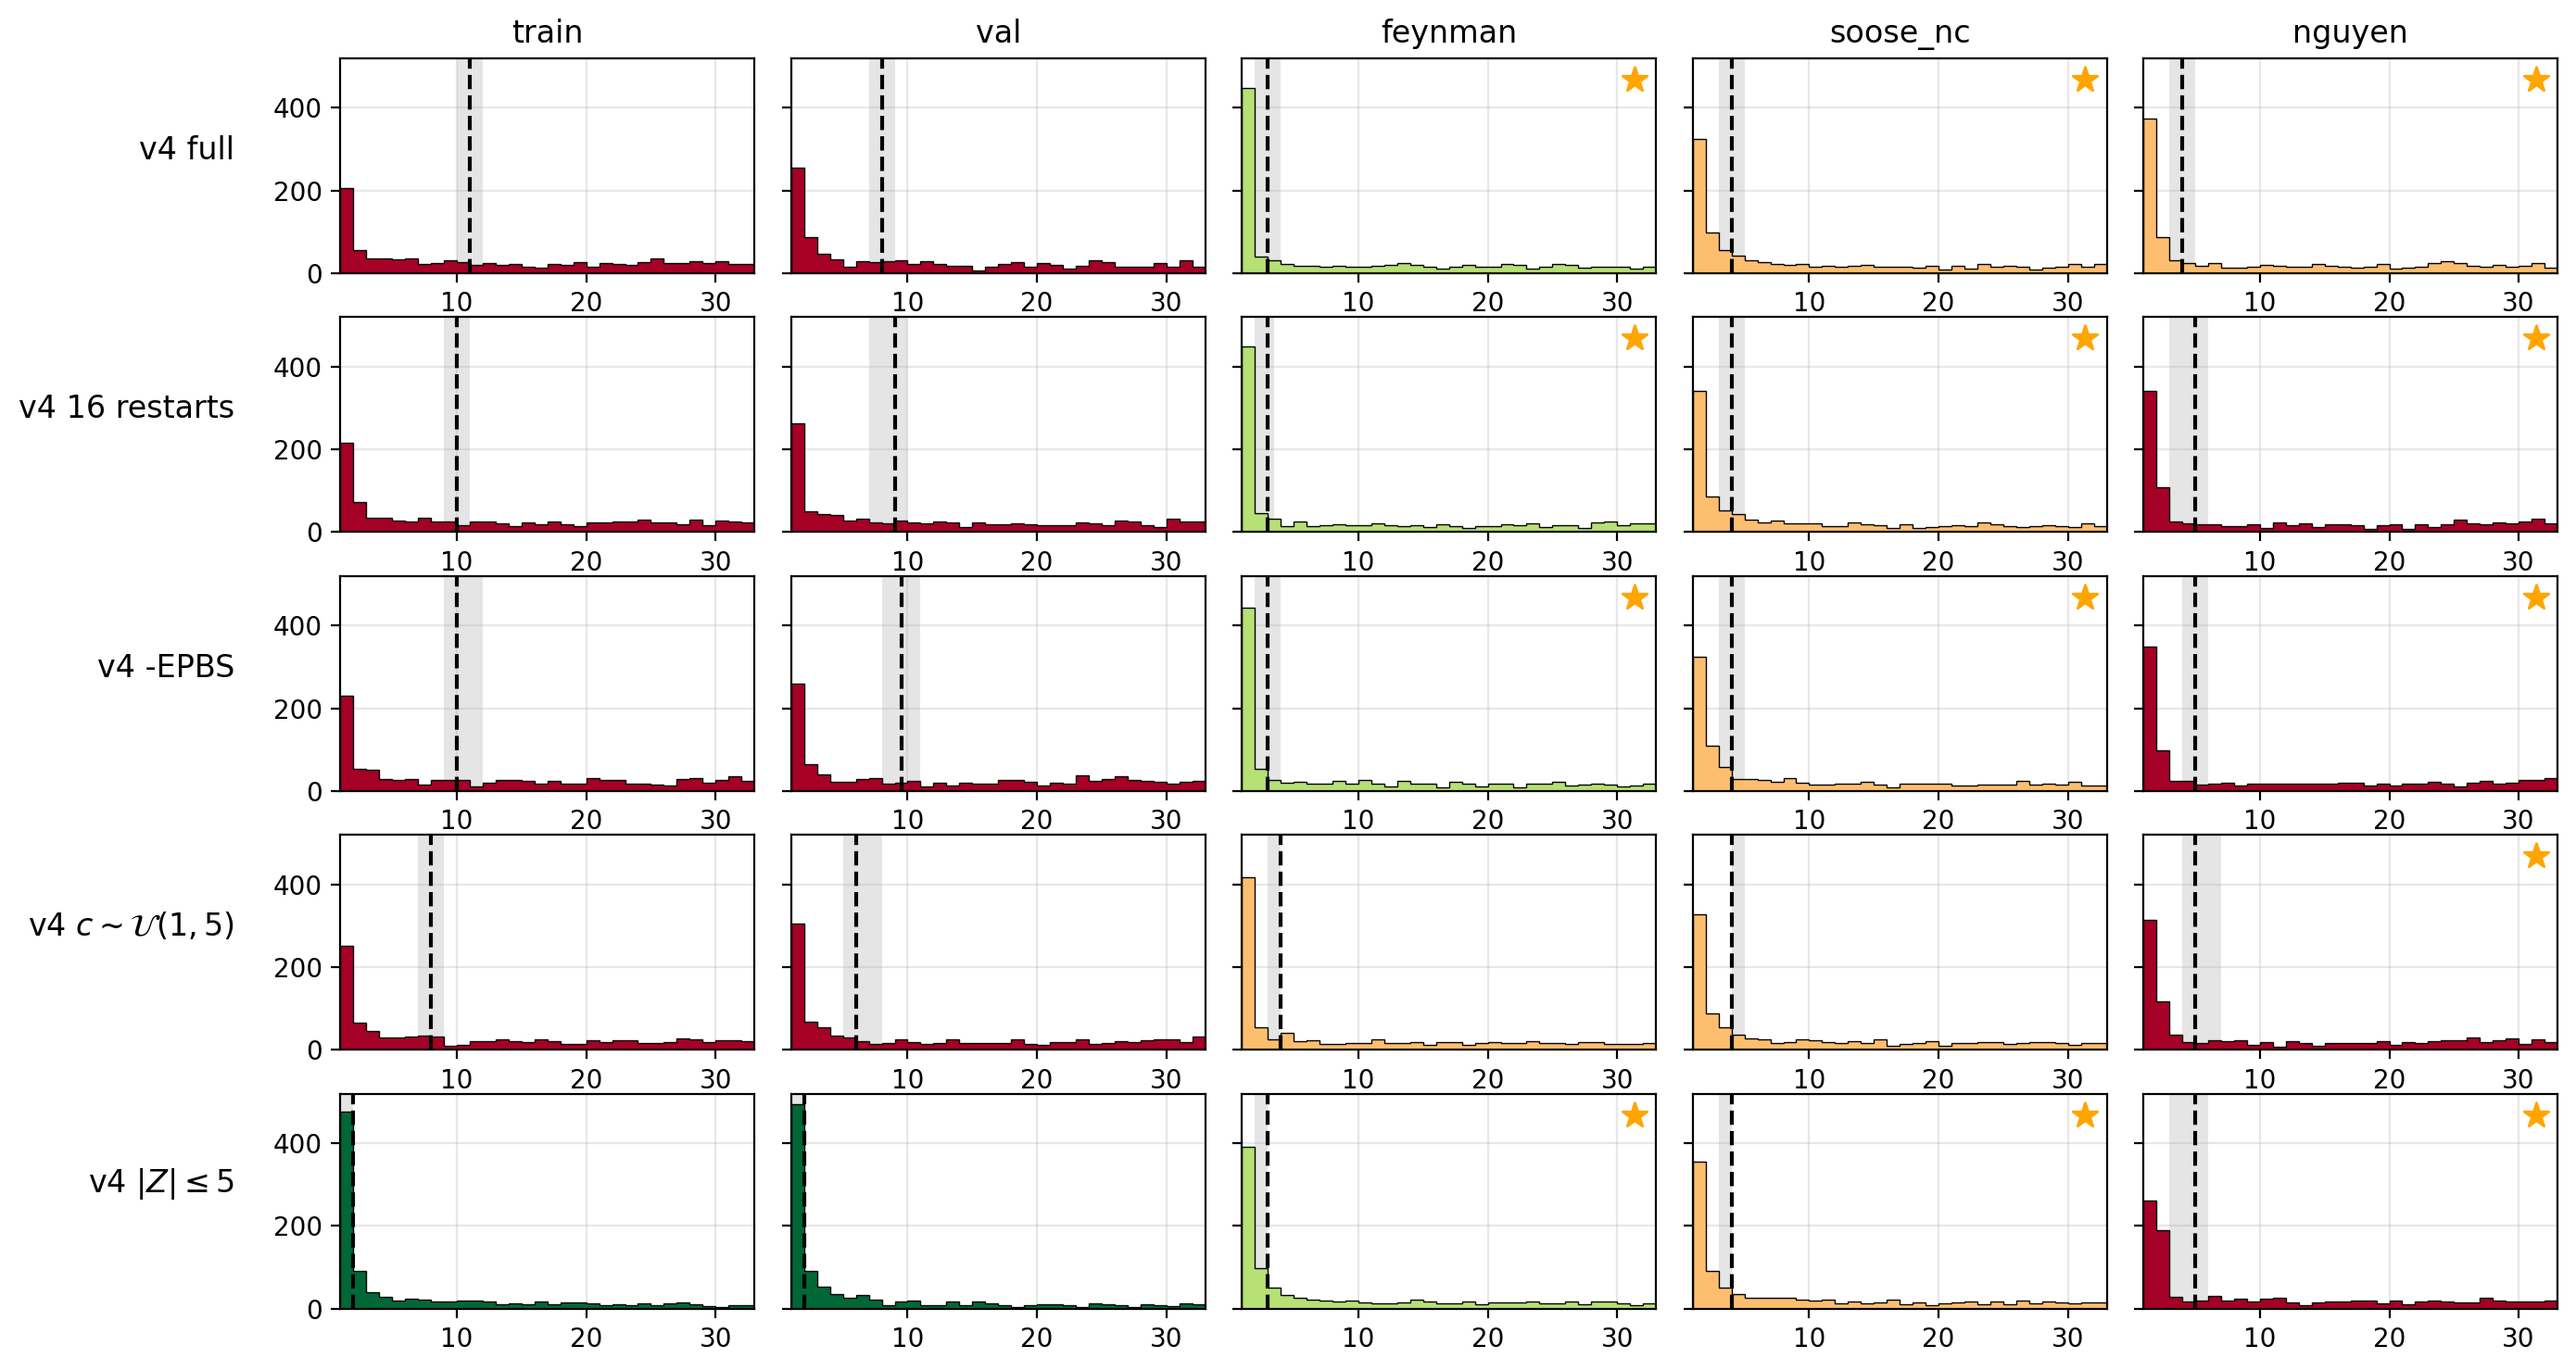

In [ ]:
ROWS = len(MODELS_WITH_BEAMS)
COLS = max(len(model_test_sets) for model_test_sets in test_sets.values())
fig, axes = plt.subplots(ROWS, COLS, figsize=(2.8 * COLS, 1.5 * ROWS), sharey=True, dpi=200)
N_BOOTSTRAPS = 1000
metric_name = 'best_beam'

xlim = (1, 33)
bins = np.linspace(*xlim, 33)
ylim = (0, 1.05 * max([max(np.histogram(array_dfs[model][test_set].get(metric_name, np.array([np.nan])), bins=bins)[0]) for model in MODELS_WITH_BEAMS for test_set in test_sets[model]]))

# Plot the distributions of a given metric for each model and test set
color_metric = np.median

min_color_metric = np.nanmin([np.nanmin([color_metric(array_dfs[model][test_set].get(metric_name, pd.Series([np.nan]))) for test_set in test_sets[model]]) for model in MODELS_WITH_BEAMS])
max_color_metric = np.nanmax([np.nanmax([color_metric(array_dfs[model][test_set].get(metric_name, pd.Series([np.nan]))) for test_set in test_sets[model]]) for model in MODELS_WITH_BEAMS])

highest_lower_confidence_bound = {test_set: (None, np.inf) for test_set in TEST_SETS}

for i, model in enumerate(MODELS_WITH_BEAMS):
    for j, test_set in enumerate(TEST_SETS):
        ax = axes[i, j]
        # ax.set_xticks(range(xlim[0], xlim[1] + 1))
        # ax.set_xticklabels([int_to_10(10**i) for i in range(xlim[0], xlim[1] + 1)], fontdict={'fontsize': 5 if i != len(MODELS) - 1 else 12})
        if j == 0: ax.set_ylabel(MODELS_DESCRIPTION[model], rotation=0, labelpad=15, ha='right', fontsize=12)
        if i == len(MODELS) - 1: ax.set_xlabel(r'$\text{PPL}\,\,\downarrow$')
        if test_set not in array_dfs[model] or metric_name not in array_dfs[model][test_set] or array_dfs[model][test_set][metric_name].isnull().all():
            ax.set_xlim(xlim)
            ax.set_facecolor('lightgrey')
            continue
        data = array_dfs[model][test_set].get(metric_name, pd.Series([np.nan])).replace(np.nan, np.inf)
        ax.hist(data, bins=bins, color=plt.get_cmap('RdYlGn').reversed()((color_metric(data) - min_color_metric) / (max_color_metric - min_color_metric)), zorder=2)
        ax.hist(data, bins=bins, zorder=2, histtype='step', edgecolor='k', linewidth=0.5)

        median_median, median_5, median_95 = bootstrapped_metric_ci(data, np.median, n=N_BOOTSTRAPS)

        if median_5 < highest_lower_confidence_bound[test_set][1]:
            highest_lower_confidence_bound[test_set] = (model, median_95)

        ax.axvline(median_median, color='black', linestyle='--', zorder=3)
        # ax.errorbar(median_median, ylim[1], xerr=[[median_median - median_5], [median_95 - median_median]], fmt='.', color='black', zorder=4, capsize=3, markersize=0, clip_on=True)
        ax.axvspan(median_5, median_95, color='black', alpha=0.1, zorder=1, linewidth=0)
        ax.set_ylim(ylim)
        ax.grid(alpha=0.3, zorder=0)
        if i == 0: ax.set_title(test_set)
        ax.set_xlim(xlim)

within_lowest_upper_confidence_bound = {test_set: [] for test_set in TEST_SETS}
for i, model in enumerate(MODELS):
    for j, test_set in enumerate(TEST_SETS):
        if test_set not in array_dfs[model]:
            continue
        data = array_dfs[model][test_set].get(metric_name, pd.Series([np.nan])).replace(np.nan, np.inf)
        median_median, median_5, median_95 = bootstrapped_metric_ci(data, np.median, n=N_BOOTSTRAPS)

        if median_5 < highest_lower_confidence_bound[test_set][1]:
            within_lowest_upper_confidence_bound[test_set].append(model)

# For each test set, mark the model (row) with the lowest median log_fvu
for j, test_set in enumerate(TEST_SETS):
    if test_set in ['train', 'val']:
        continue
    models = within_lowest_upper_confidence_bound[test_set]
    for i, model in enumerate(MODELS_WITH_BEAMS):
        if model in models:
            axes[MODELS.index(model), j].scatter([xlim[1] * 0.95], [ylim[1] * 0.9], color='orange', marker='*', s=100, zorder=5)

fig.tight_layout(h_pad=0)

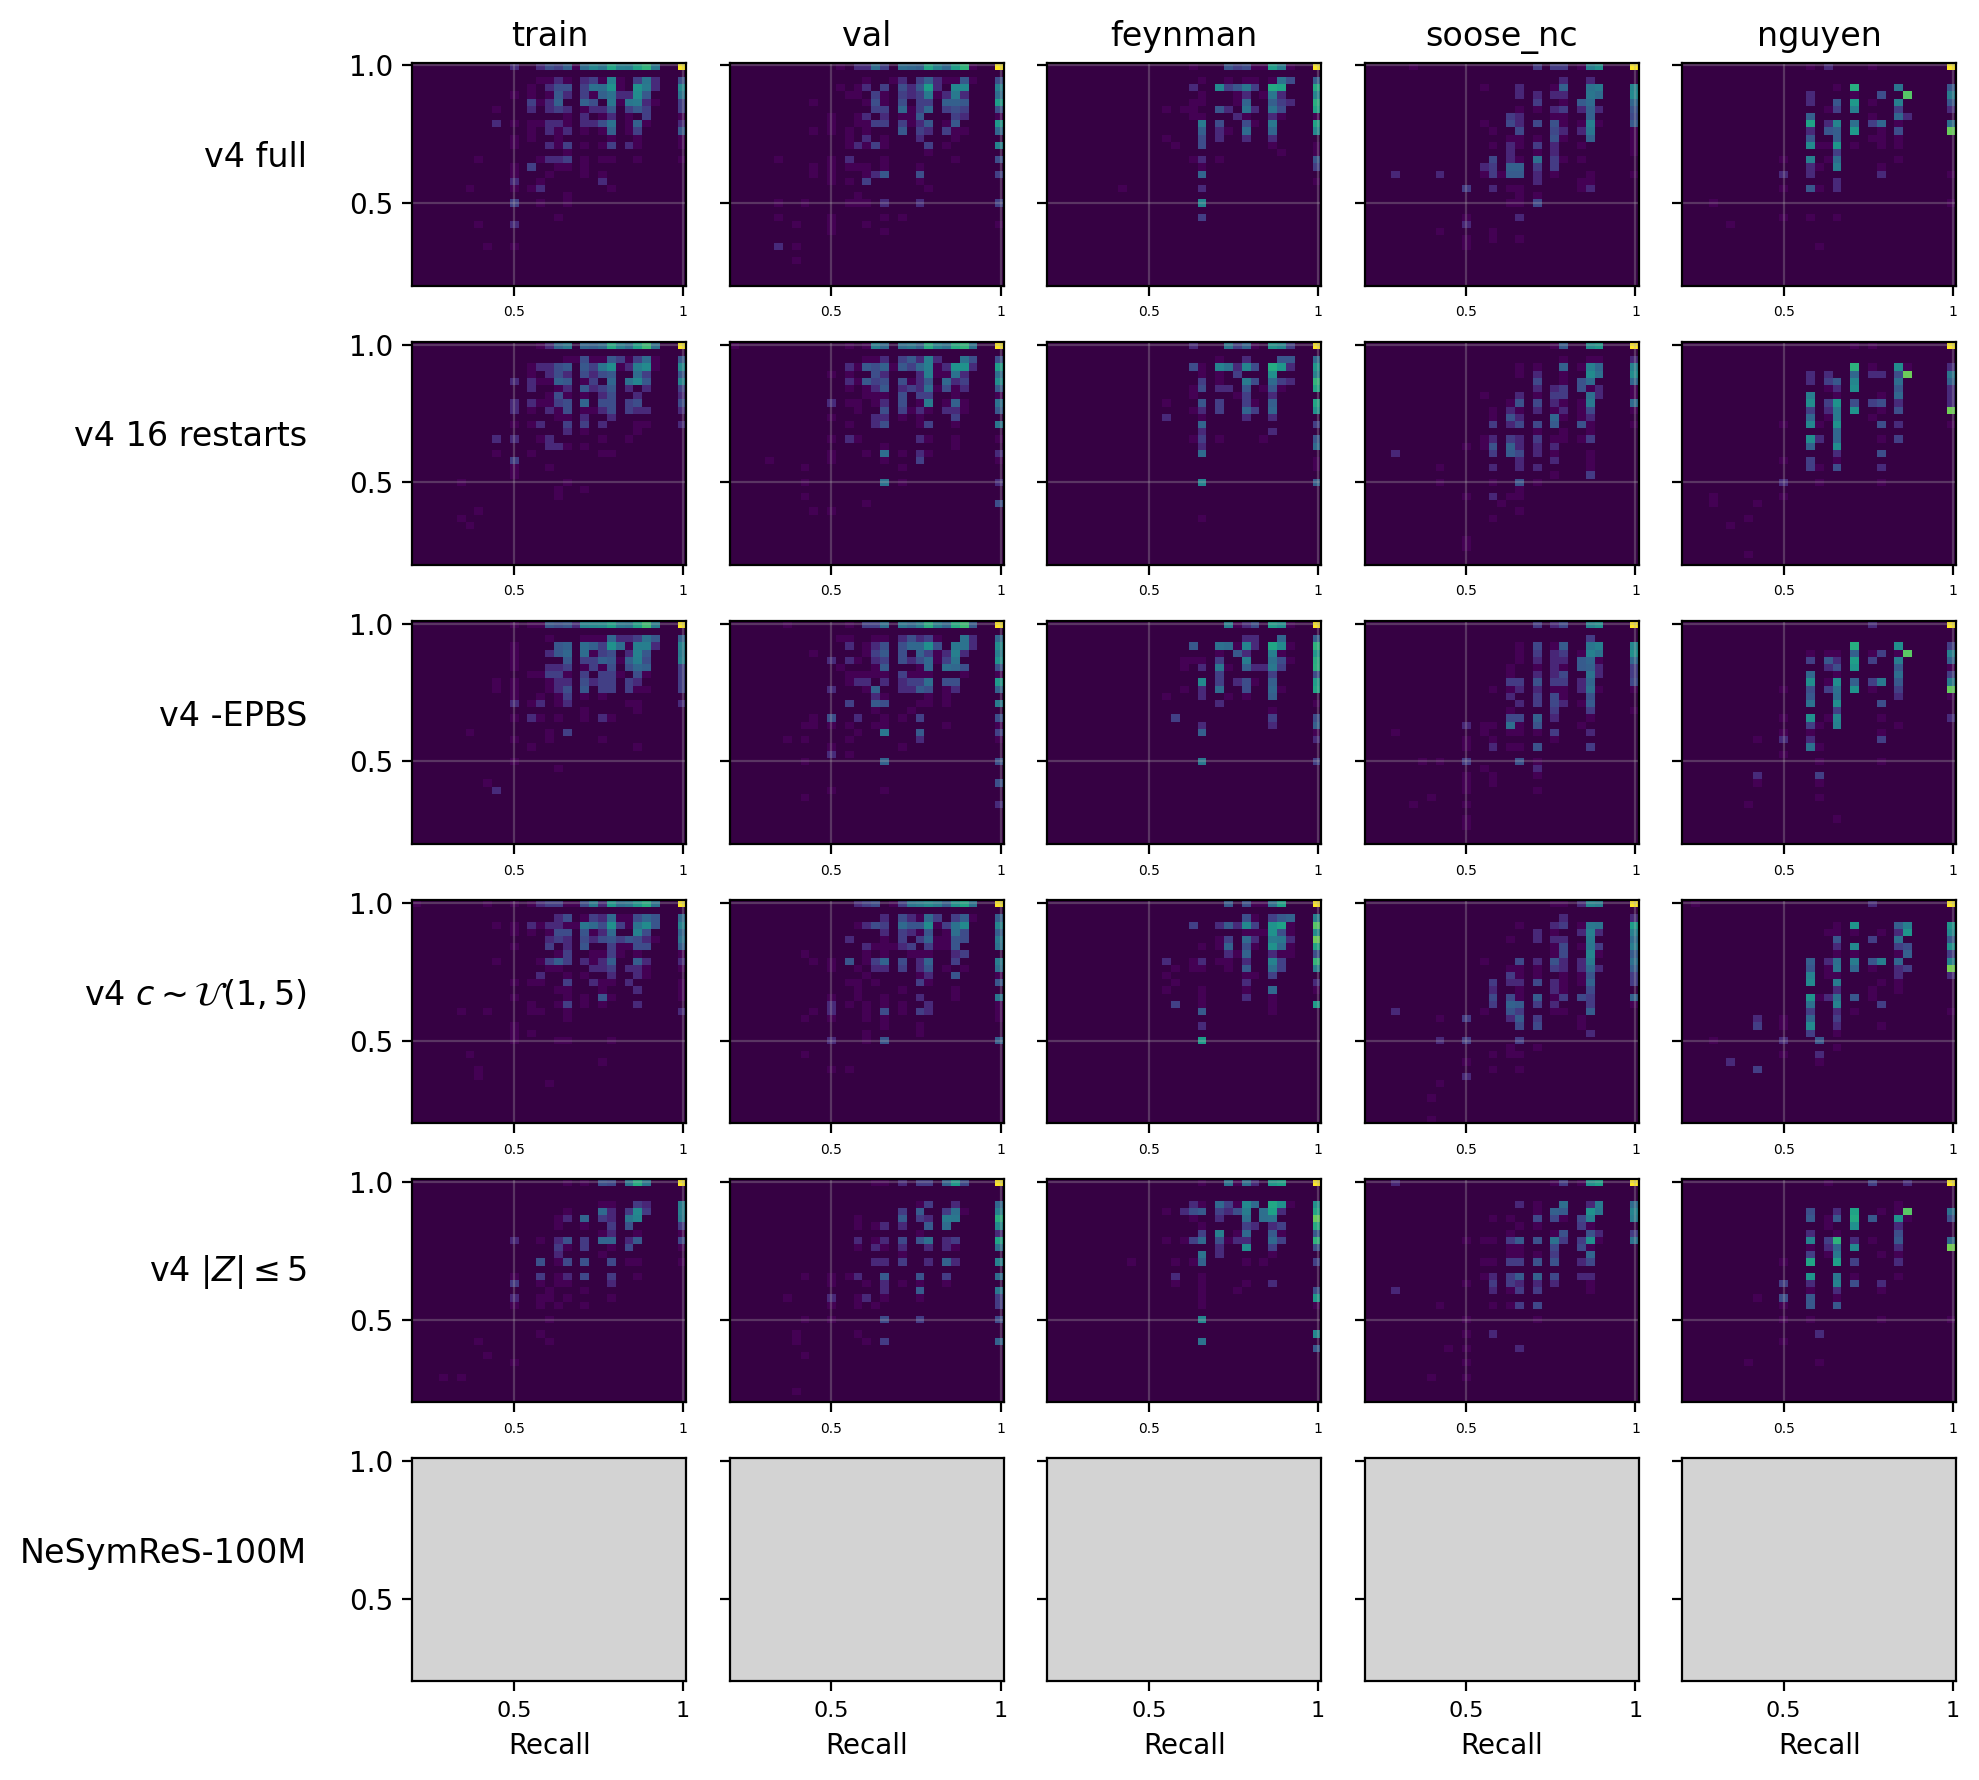

In [ ]:
# For each model and test set, scatter plot the recall-precision curve
ROWS = len(MODELS)
COLS = max(len(model_test_sets) for model_test_sets in test_sets.values())
fig, axes = plt.subplots(ROWS, COLS, figsize=(2 * COLS, 1.5 * ROWS), sharey=True, dpi=200)

metric_name_x = 'recall_best_beam'
metric_name_y = 'precision_best_beam'

xlim = (0.2, 1.01)
ylim = xlim

bins = np.linspace(*xlim, 32)

for i, model in enumerate(MODELS):
    for j, test_set in enumerate(TEST_SETS):
        ax = axes[i, j]
        ax.set_xticks([0.5, 1])
        ax.set_yticks([0.5, 1])
        ax.set_xticklabels([0.5, 1], fontdict={'fontsize': 5 if i != len(MODELS) - 1 else 8})
        if j == 0: ax.set_ylabel(MODELS_DESCRIPTION[model], rotation=0, labelpad=15, ha='right', fontsize=12)
        if i == len(MODELS) - 1: ax.set_xlabel('Recall')
        if test_set not in array_dfs[model] or metric_name_x not in array_dfs[model][test_set] or metric_name_y not in array_dfs[model][test_set]:
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.set_facecolor('lightgrey')
            continue
        data_x = array_dfs[model][test_set].get(metric_name_x, pd.Series([np.nan])).replace(np.nan, 0)
        data_y = array_dfs[model][test_set].get(metric_name_y, pd.Series([np.nan])).replace(np.nan, 0)
        ax.hist2d(data_x, data_y, bins=bins, cmap='viridis', norm=plt.cm.colors.LogNorm())
        ax.set_facecolor(tuple(np.array(plt.get_cmap('viridis')(0)[:3]) * 0.8) + (1, ))
        # ax.scatter(data_x, data_y, s=1, zorder=2, alpha=0.5)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.grid(alpha=0.3, zorder=0)
        if i == 0: ax.set_title(test_set)

fig.tight_layout(h_pad=0.5)